

# Data Science Workshop in Ivano-Frankivsk on April 2018

## by Tatyana Gladkyh and Dmytro Zikrach (DSG, SoftServe)

# 1. Load modules

In [47]:
!pip3 install --user tqdm statsmodels

In [48]:
%matplotlib inline
import base64
import numpy as np
import pandas as pd
from io import BytesIO
from itertools import combinations
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, r2_score, mean_squared_error


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

import statsmodels.api as sm

from IPython.display import HTML, Image

In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Define functions for output models result

In [50]:
sns.set()

def prepare_data(X, y):
    """
    Convert and split data
    """
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in split.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

def evaluate_classification(actual, pred, pos_label=1, average='binary', sample_weight = None, fs=4):
    """
    Basic set of evaluation metrics for classification
    """
    return """
    <table style='width:100%'><tr><td style='text-align:left;vertical-align:top'><table style='font-size:14px'> \
    <tr><td><b>Accuracy score:</b></td><td>{1}</td></tr><tr><td><b>F1 score:</b></td><td>{2}</td></tr></table></td> \
    <td>{0}</td></tr></table>
    """.format(confusion_matrix_picture(actual, pred, fs=fs), 
               metrics.accuracy_score(actual, pred, sample_weight=sample_weight), metrics.f1_score(actual, pred, pos_label=pos_label, average=average))

def evaluate_regression(actual, pred, sample_weight = None):
    """
    Basic set of evaluation metrics for regression
    """
    print("RMSE: {}".format(np.sqrt(metrics.mean_squared_error(actual, pred, sample_weight=sample_weight))))
    print("R^2 score: {}".format(metrics.r2_score(actual, pred, sample_weight=sample_weight)))
    df=pd.DataFrame({'actual':actual, 'pred':pred})
    _=df.boxplot('pred','actual', figsize=[7,5])
    _=df.hist('pred','actual', figsize=[7,7])

def evaluate_hclust(actual, link):
    """
    Evaluate hierarchical clustering by plotting several metrics against various number of clusters
    actual -- known instance labels
    link -- result of scipy's linkage function
    """
    amis, chs, ss, vs = [], [], [], []
    for k in range(2,51):
        clusters = fcluster(link, k, 'maxclust')
        amis.append(metrics.adjusted_mutual_info_score(actual, clusters))
        chs.append(metrics.calinski_harabaz_score(X, clusters))
        vs.append(metrics.v_measure_score(actual, clusters))
        ss.append(metrics.silhouette_score(X, clusters))
        
    fig, rows = plt.subplots(2, 2, figsize=(15,10))
    rows[0][0].plot(range(2,51), amis)
    rows[0][0].set_xlim(2,50)
    rows[0][0].set_title("adjusted mutual info score")
    rows[0][1].plot(range(2,51), chs)
    rows[0][1].set_xlim(2,50)
    rows[0][1].set_title("calinski harabas score")
    rows[1][0].plot(range(2,51), vs)
    rows[1][0].set_xlim(2,50)
    rows[1][0].set_title("v-score")
    rows[1][1].plot(range(2,51), ss)
    rows[1][1].set_xlim(2,50)
    rows[1][1].set_title("silhouette score")

def confusion_matrix(actual, pred):
    """
    Confusion matrix in html form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False)
    return cm.to_html().replace('class="dataframe', 'style="font-size:14px"')

def confusion_matrix_picture(actual, pred, fs = 4):
    """
    Confusion matrix in heatmap form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False, 
                     normalize='index')
    fig, ax = plt.subplots(figsize=(fs,fs))
    itm = sns.heatmap(cm, annot=True, linewidths=.5, cmap=plt.cm.viridis_r, ax=ax)
    img = BytesIO()
    fig.savefig(img, format='png')
    plt.close(fig)
    return '<img src="data:image/png;base64,{}"\>'.format(base64.b64encode(img.getvalue()).decode('utf-8'))

def plot_roc_single(actual, score, rev=True, labels={}, fsize=[10,5]):
    """
    Plot single ROC curve
    """
    fig, ax = plt.subplots(figsize=(fsize[0], fsize[1]))
    _plot_roc_curve(ax, actual, score, rev, labels)
    plt.show()

def plot_roc_multiple(actual, score, rev=True, labels={}, titles=[]):
    """
    Plot multiple ROC curves in a 2 cell grid
    """
    num_plots = actual.shape[1]
    nrows = num_plots // 2 if num_plots % 2 == 0 else num_plots // 2 + 1
    fig, axes = plt.subplots(nrows, 2, squeeze=False, figsize=(26, 7 * nrows))
    for idx, row in enumerate(axes):
        title = "ROC for {}".format(titles[idx*2] if idx*2 < len(titles) else 'None')
        _plot_roc_curve(row[0], actual[:, idx*2], score[:, idx*2], rev, labels, title)
        if idx*2+1 < num_plots:
            title = "ROC for {}".format(titles[idx*2+1] if idx*2+1 < len(titles) else 'None')
            _plot_roc_curve(row[1], actual[:, idx*2+1], score[:, idx*2+1], rev, labels, title)
        else:
            fig.delaxes(row[1])
    plt.show()

def _get_data_for(x, y, label):
    """
    Get actual, predicted data for specified label
    """
    idx = np.where(x == label)[0]
    return x[idx], y[idx]

def _plot_roc_curve(ax, actual, score, rev=True, labels={}, title='Receiver operating characteristic'):
    """
    Plot ROC curve with AUC characteristic and baseline for binary case
    """
    fnc=np.vectorize(lambda t: labels.get(t, t))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if rev:
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(fnc(actual).ravel(), score.ravel())
    else:
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(fnc(actual), score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    k='micro'
    ax.plot(fpr[k], tpr[k], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[k])
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Code by Joe Kington
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def background_gradient(s, cmap='bwr', low=0, high=0):
    """
    Color correlations table according to specified colormap
    """
    rng = s.max() - s.min()
    norm = MidpointNormalize(s.min() - (rng * low), s.max() + (rng * high), 0)
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

def magnify():
    """
    Zoom-in table cell on mouse point
    """
    return [dict(selector="th",
                 props=[("font-size", "10pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "14pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '14pt')])]

def confusion_matrix_simple(actual, pred):
    """
    Confusion matrix in html form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False,
                    normalize='index')
    return cm


def clust_matrix_picture(cm, fs = 4):
    """
    Confusion matrix in heatmap form
    """
    fig, ax = plt.subplots(figsize=(fs,fs))
    itm = sns.heatmap(cm, annot=True, linewidths=.5, cmap=plt.cm.viridis_r, ax=ax)
    img = BytesIO()
    fig.savefig(img, format='png')
    plt.close(fig)
    return '<img src="data:image/png;base64,{}"\>'.format(base64.b64encode(img.getvalue()).decode('utf-8'))


# 3. Load and Preparation Data

In [51]:
# Load red wine
dfr = pd.read_csv("data/winequality-red.csv", sep=';')
dfr['color'] = 'red'
# Load white wine
dfw = pd.read_csv("data/winequality-white.csv", sep=';')
dfw['color'] = 'white'
#Concatenate and shuffle data
df = pd.concat([dfr, dfw])
df = df.sample(frac=1, random_state=3).reset_index(drop=True)

In [52]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            5.9             0.180         0.28             1.0      0.037   
1           10.2             0.670         0.39             1.9      0.054   
2            8.4             0.715         0.20             2.4      0.076   
3            6.8             0.370         0.51            11.8      0.044   
4            8.9             0.750         0.14             2.5      0.086   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 24.0                  88.0  0.99094  3.29       0.55   
1                  6.0                  17.0  0.99760  3.17       0.47   
2                 10.0                  38.0  0.99735  3.31       0.64   
3                 62.0                 163.0  0.99760  3.19       0.44   
4                  9.0                  30.0  0.99824  3.34       0.64   

   alcohol  quality  color  
0    10.65        7  white  
1    10.00        5    red  
2     9.40        5    red  
3     8.80        5  white  
4    10.50        5    red

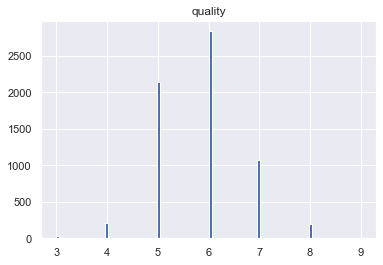

In [53]:
_ = df.hist('quality', bins=100, figsize=(6, 4))

### 3a. Extract class, based on wine quality

In [54]:
df['class'] = df.quality.apply(lambda x: "high" if x > 6 else "low")

# 4. Exploratory analysis

## 4a. Visualizing dependencies

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead

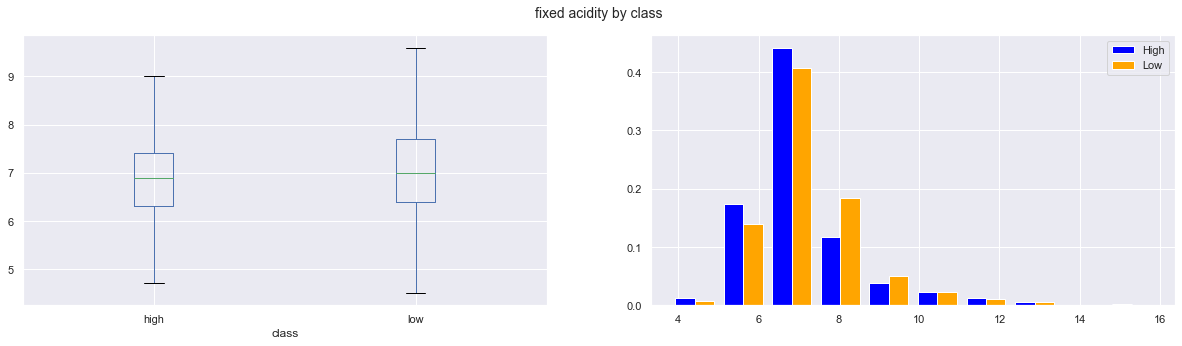

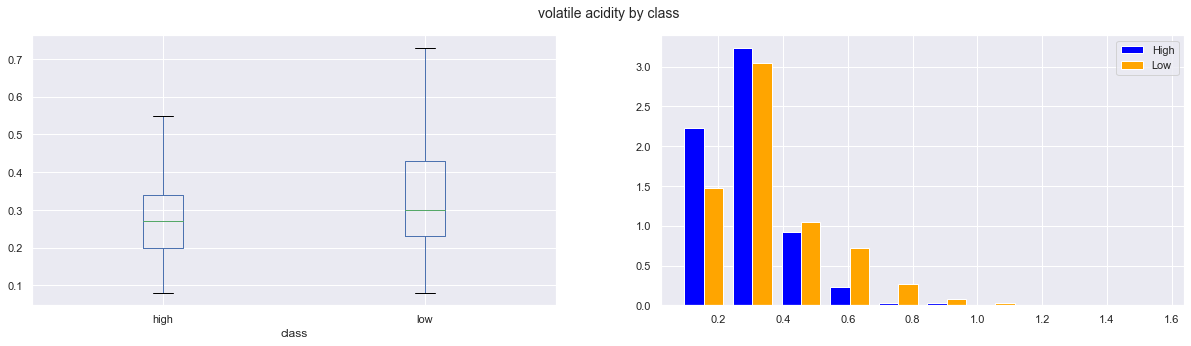

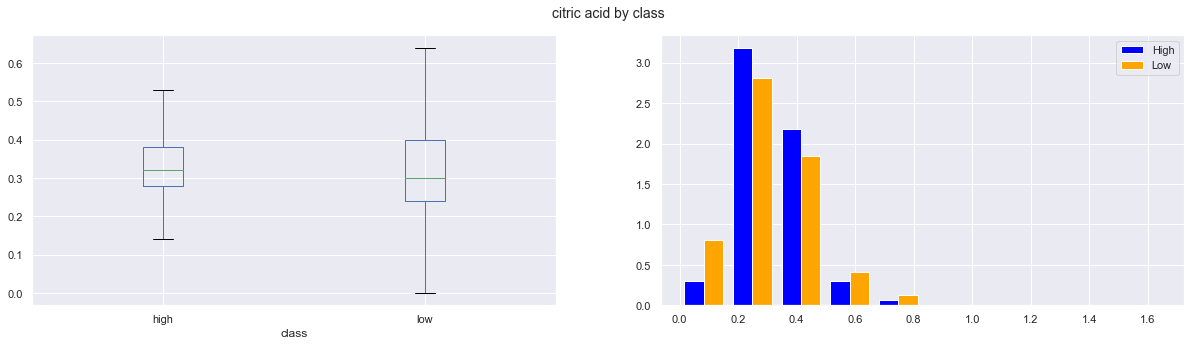

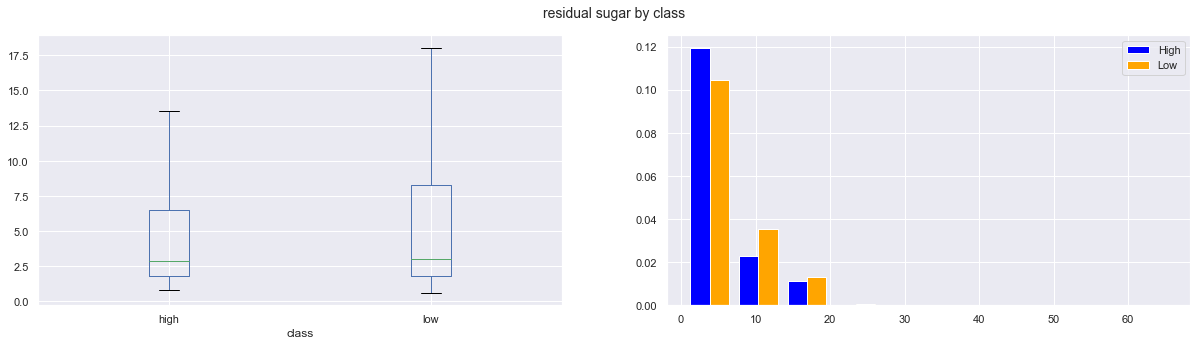

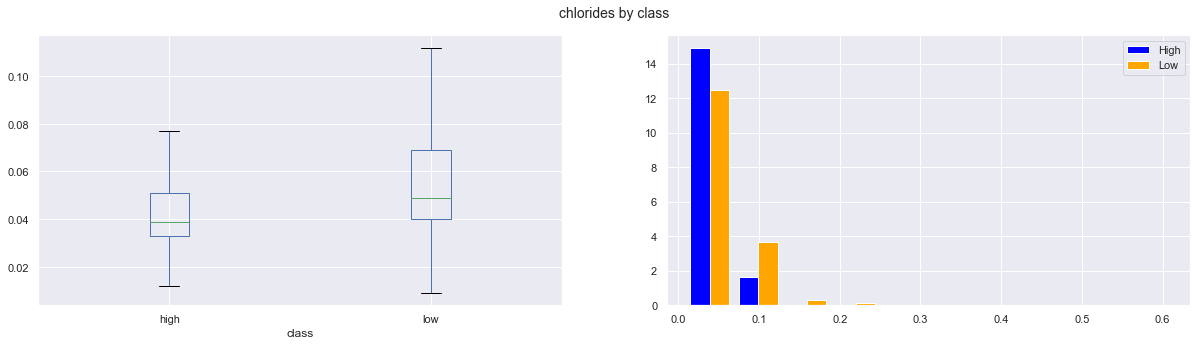

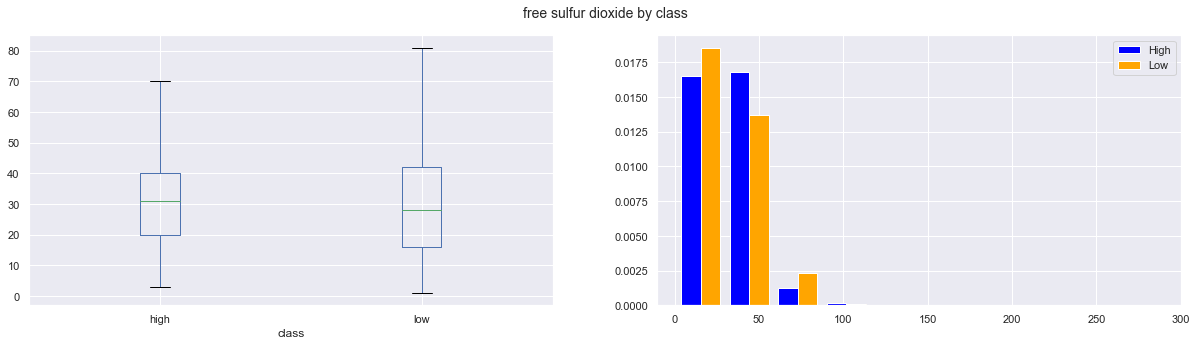

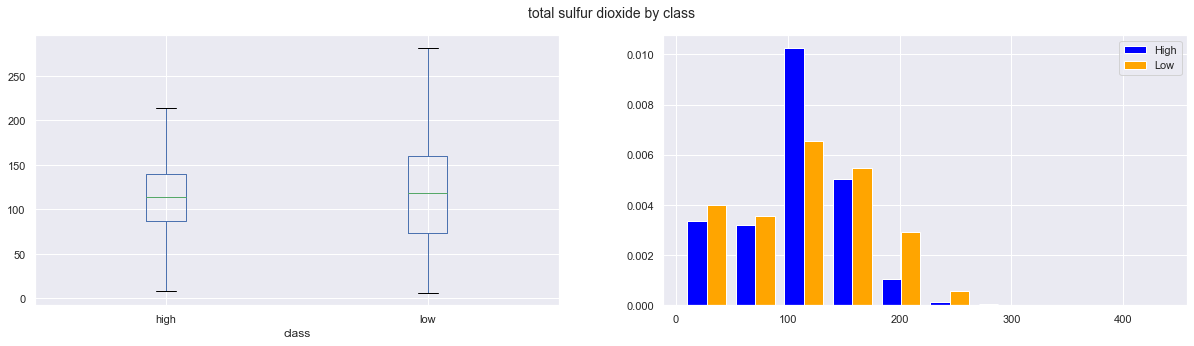

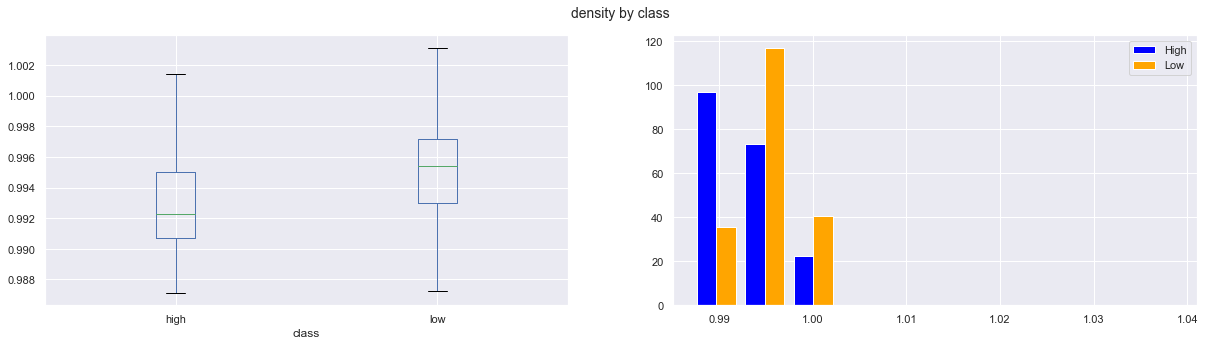

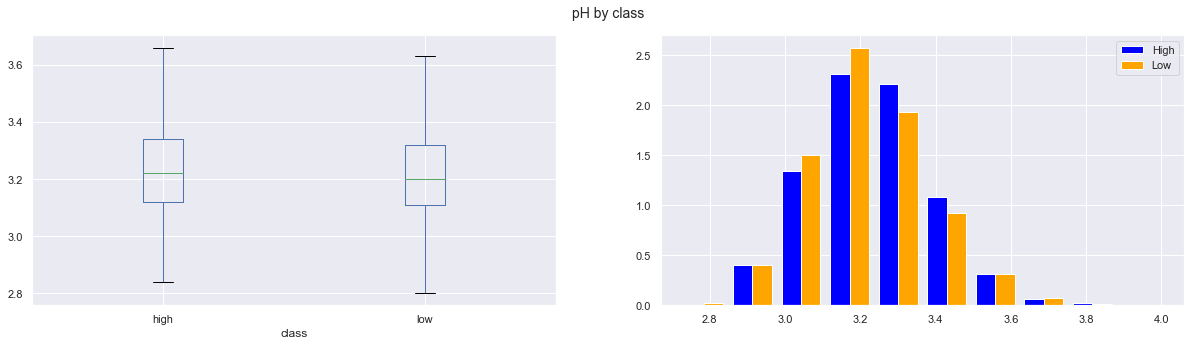

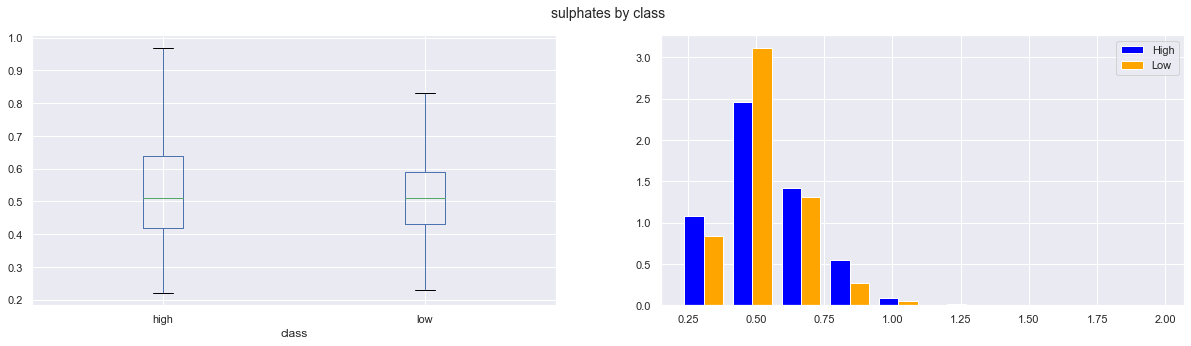

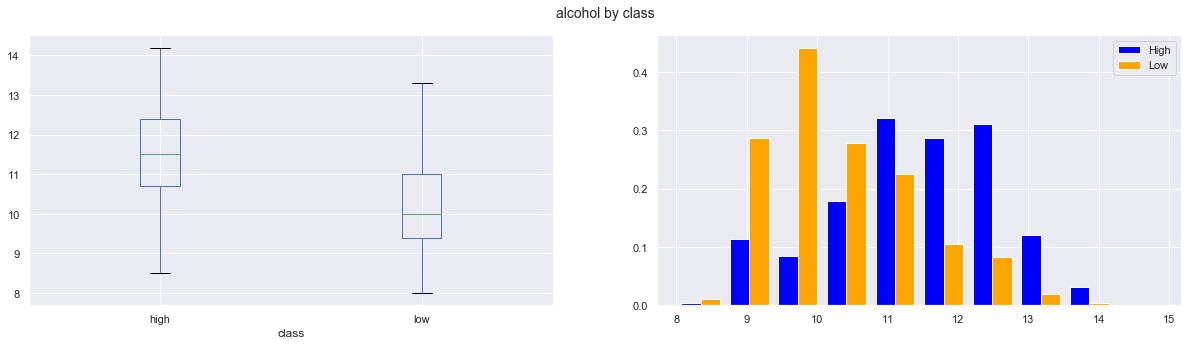

In [55]:
for column in df.columns.drop(['quality', 'color', 'class']):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
    df.boxplot(column, 'class', ax=ax1, showfliers=False)
    ax1.set_title('')
    ax2.hist([df.loc[df['class'] == 'high', column], df.loc[df['class'] == 'low', column]], 
             label=['High', "Low"], color=['blue', 'orange'], normed=True)
    ax2.legend()
    fig.suptitle('{} by class'.format(column), fontsize=14)

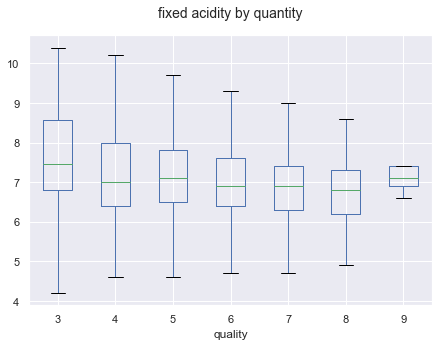

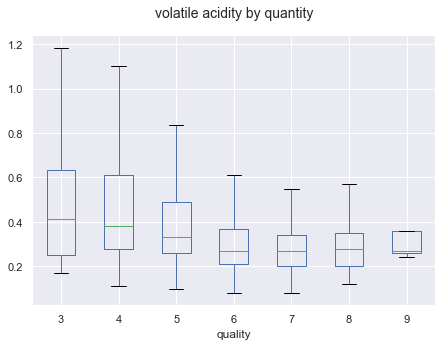

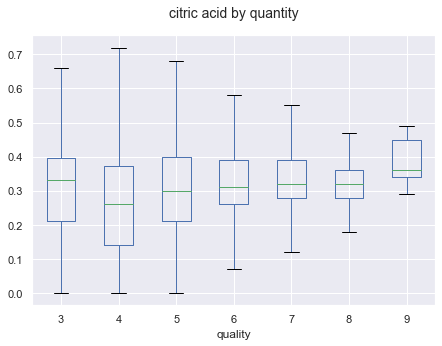

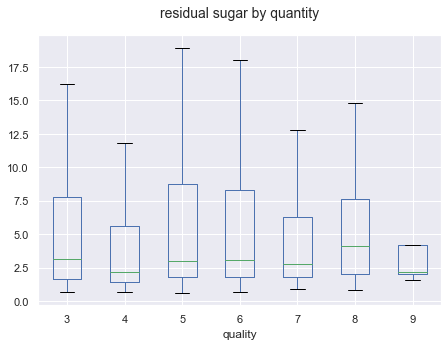

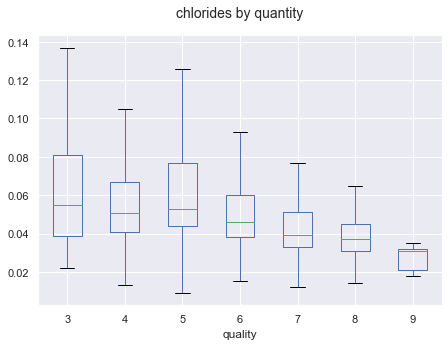

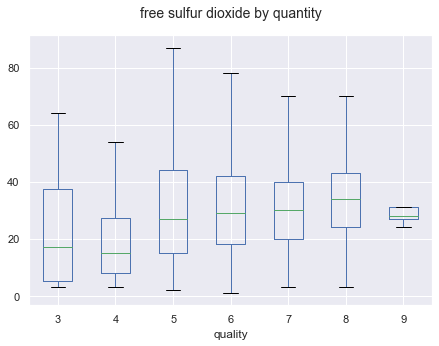

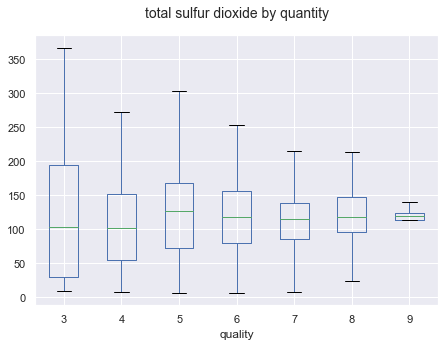

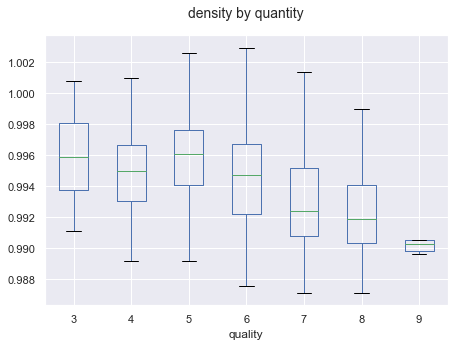

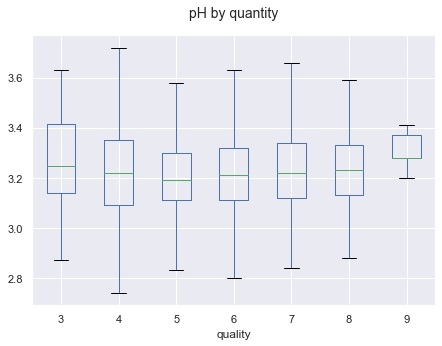

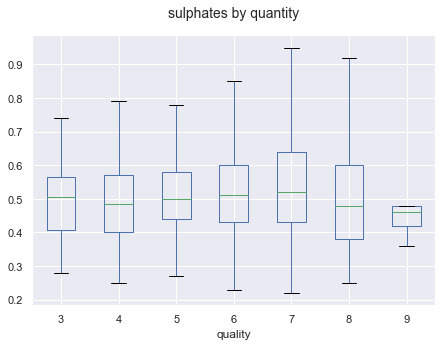

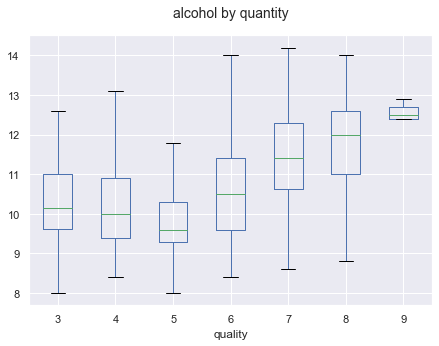

In [56]:
for column in df.columns.drop(['quality', 'color', 'class']):
    fig, ax = plt.subplots(figsize=(7,5))
    df.boxplot(column, 'quality', showfliers=False, ax=ax)
    ax.set_title('')
    fig.suptitle('{} by quantity'.format(column), fontsize=14)

## 4b. Correlation

In [57]:
df.corr().style.apply(background_gradient, axis=1) \
    .set_properties(**{'max-width': '120px', 'font-size': '12pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

## 4c. Predictors, most correlated with quality

In [58]:
vals = ['volatile acidity', 'chlorides', 'density', 'alcohol']
cc = combinations(vals, 2)

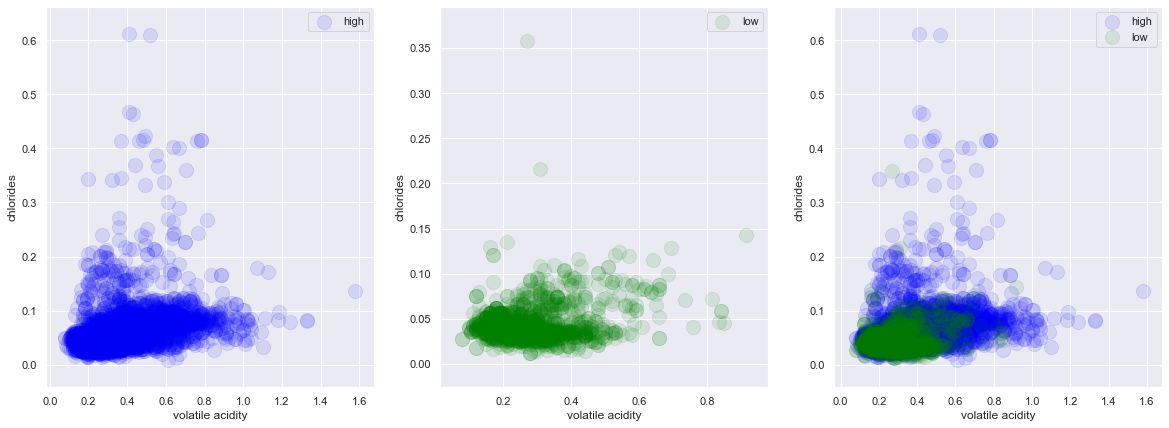

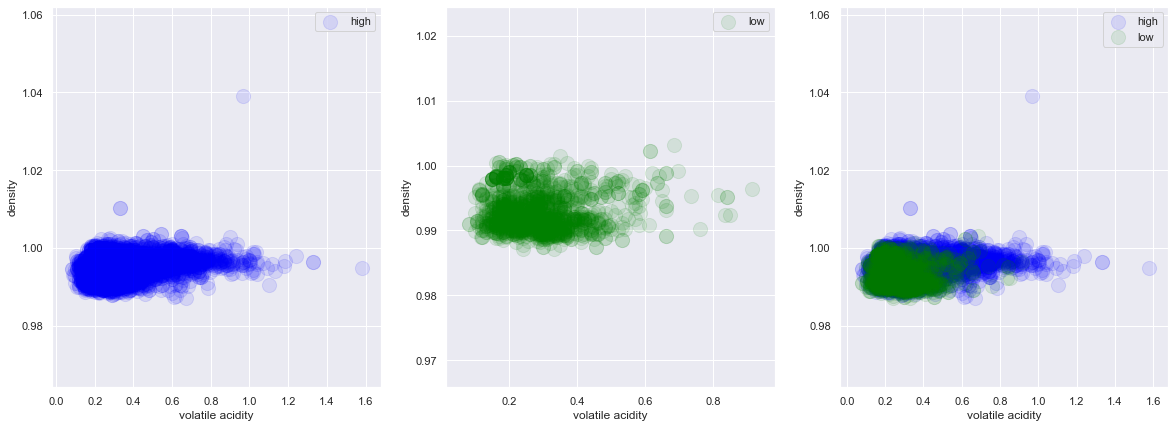

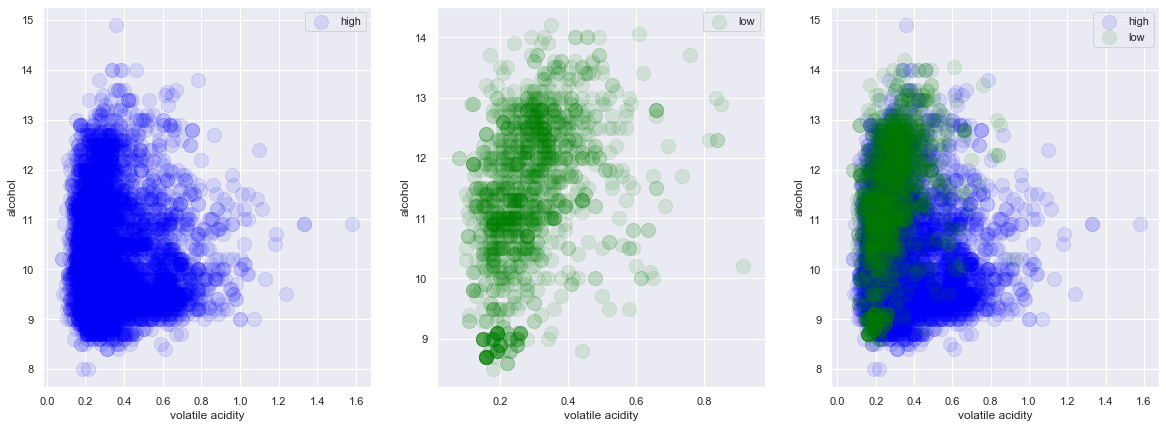

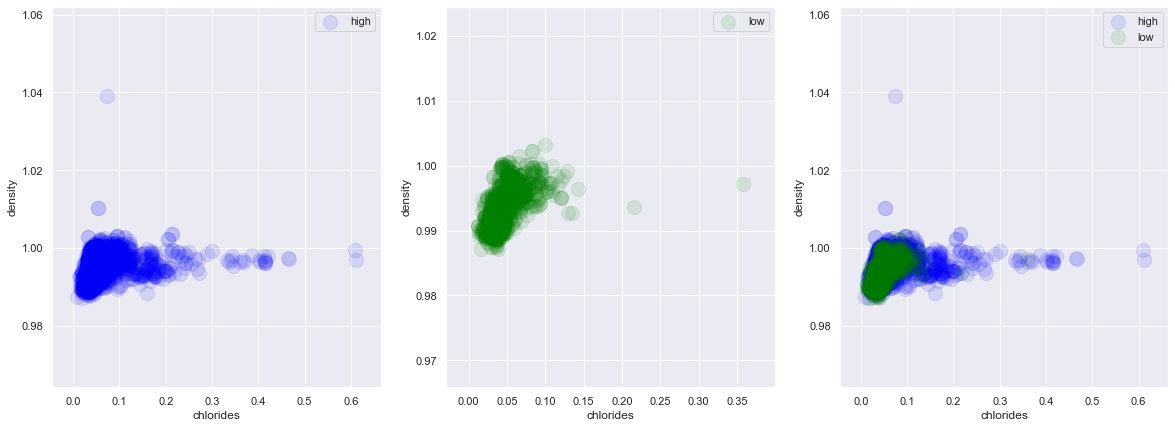

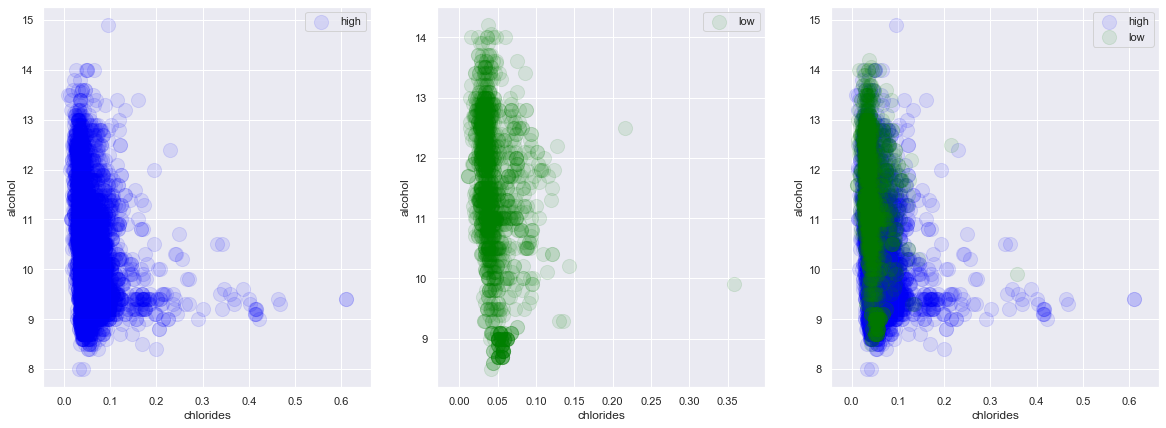

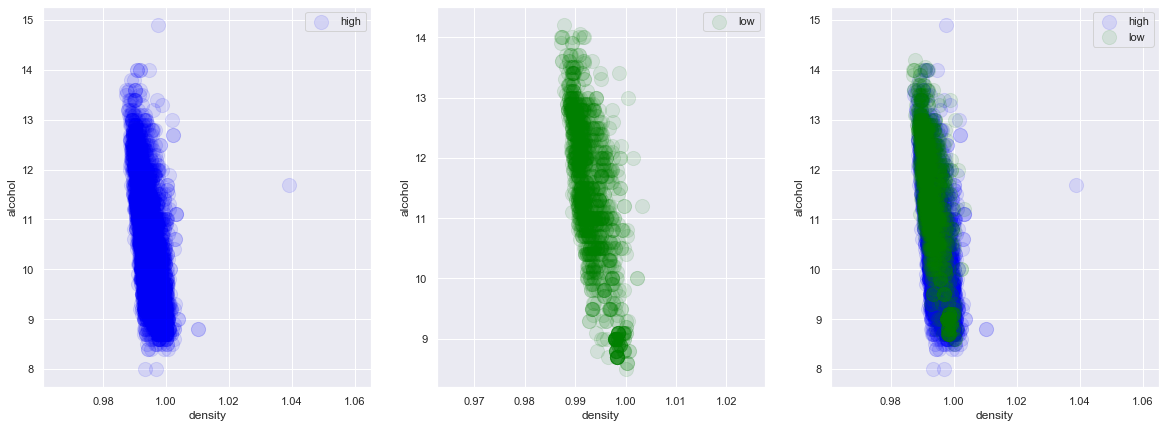

In [59]:
for k,v in combinations(vals, 2):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 7))
    sns.regplot(k,v, data=df[df['class']=='low'], fit_reg=False,  color="blue",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax1, label='high')
    ax1.legend(loc='best')
    sns.regplot(k,v, data=df[df['class']=='high'], fit_reg=False,  color="green",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax2, label='low')
    ax2.legend(loc='best')
    sns.regplot(k,v, data=df[df['class']=='low'], fit_reg=False,  color="blue",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax3, label='high')
    sns.regplot(k,v, data=df[df['class']=='high'], fit_reg=False, color="green",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax3, label='low')
    ax3.legend(loc='best')

# Modelling

# 5. Classification

## 5.1. Binary

In [60]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['class'].values)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
color                   6497 non-null object
class                   6497 non-null object
dtypes: float64(11), int64(1), object(2)
memory usage: 710.7+ KB


In [62]:
df['class'].value_counts()

low     5220
high    1277
Name: class, dtype: int64

### Logistic Regression

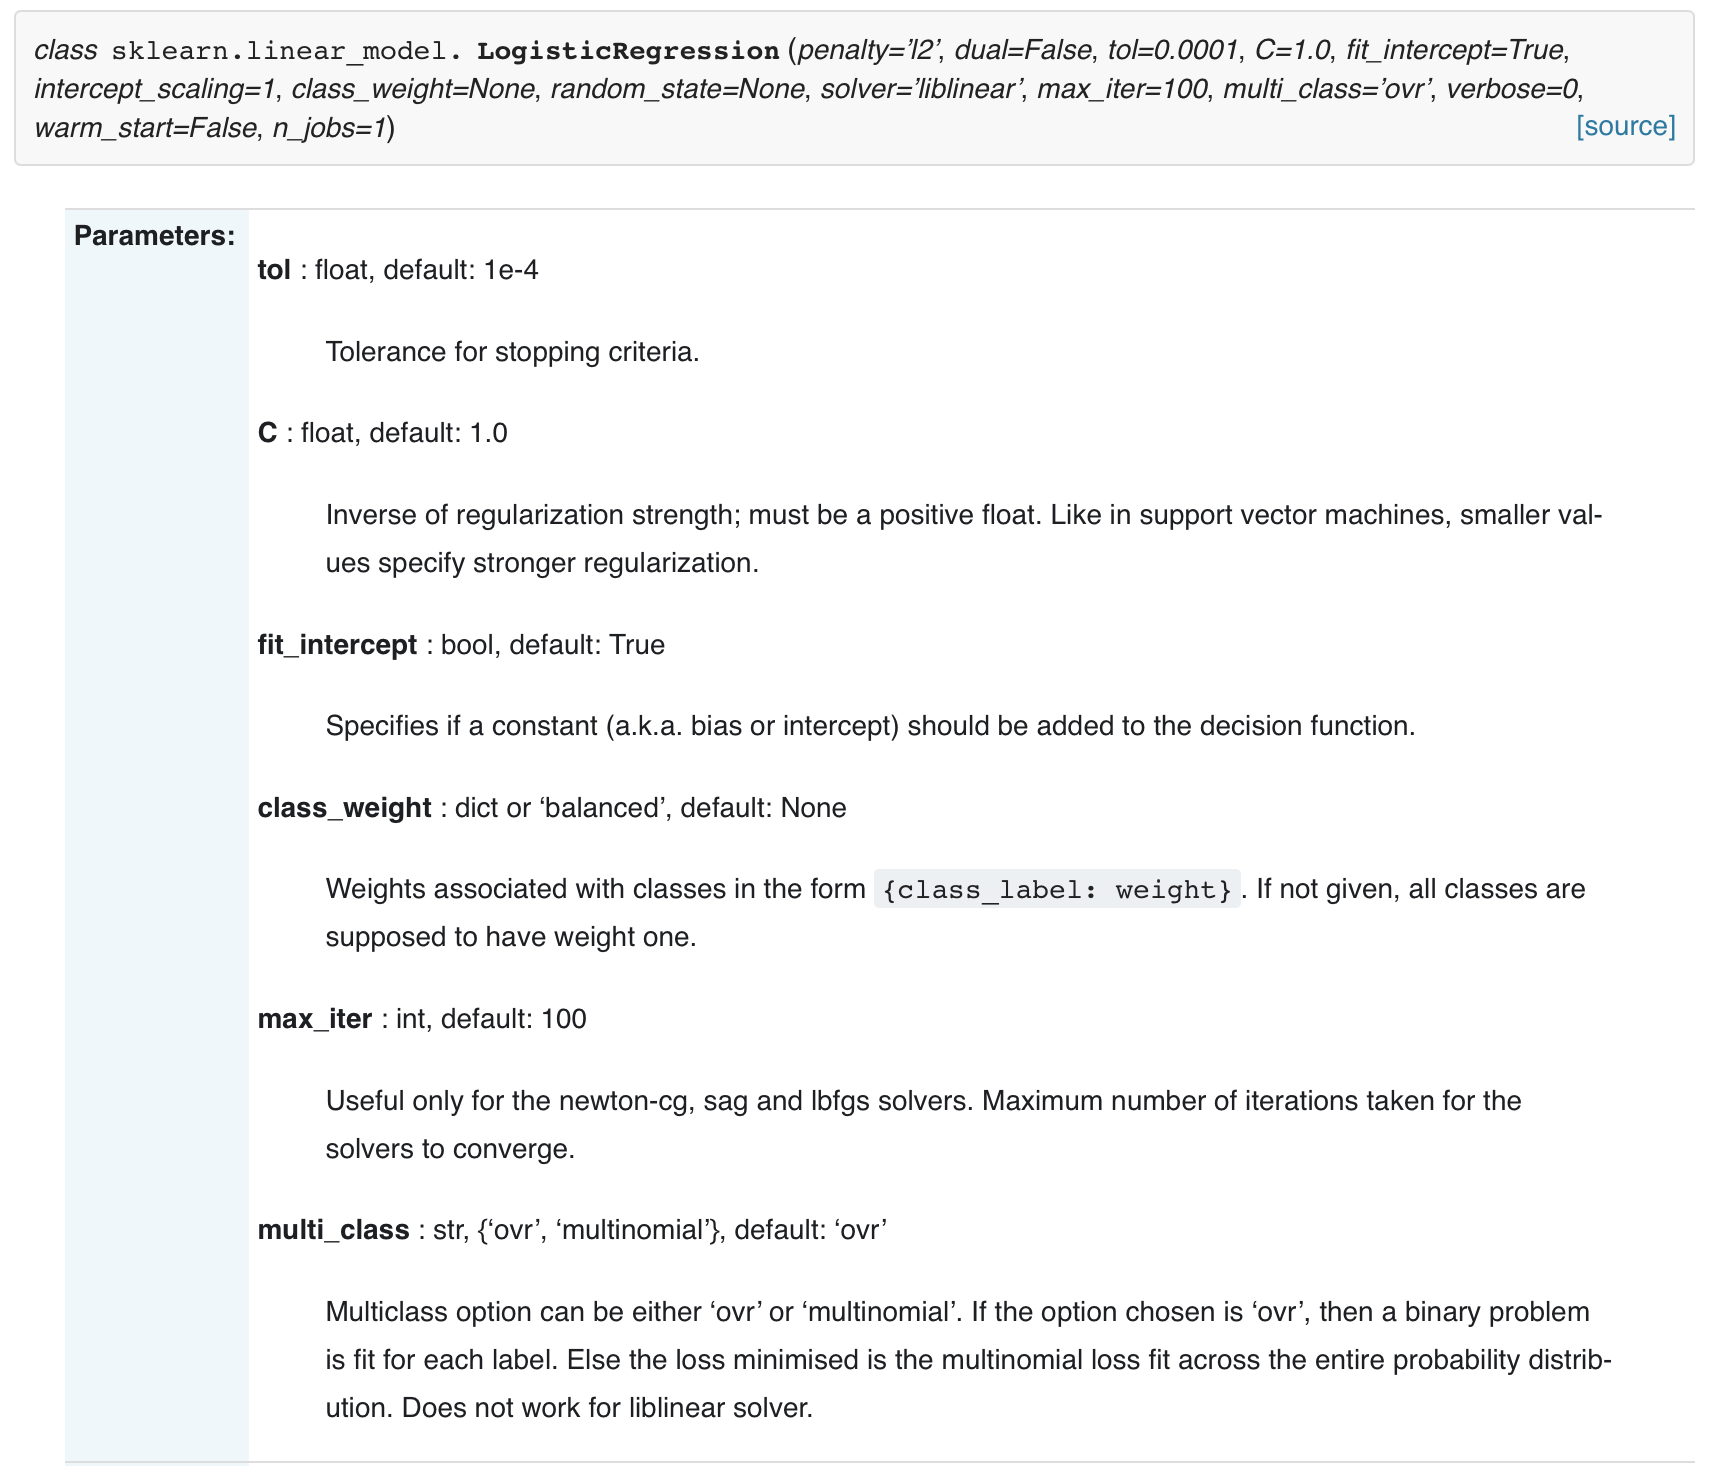

In [63]:
Image(filename='img/lg1.png', width='100%')

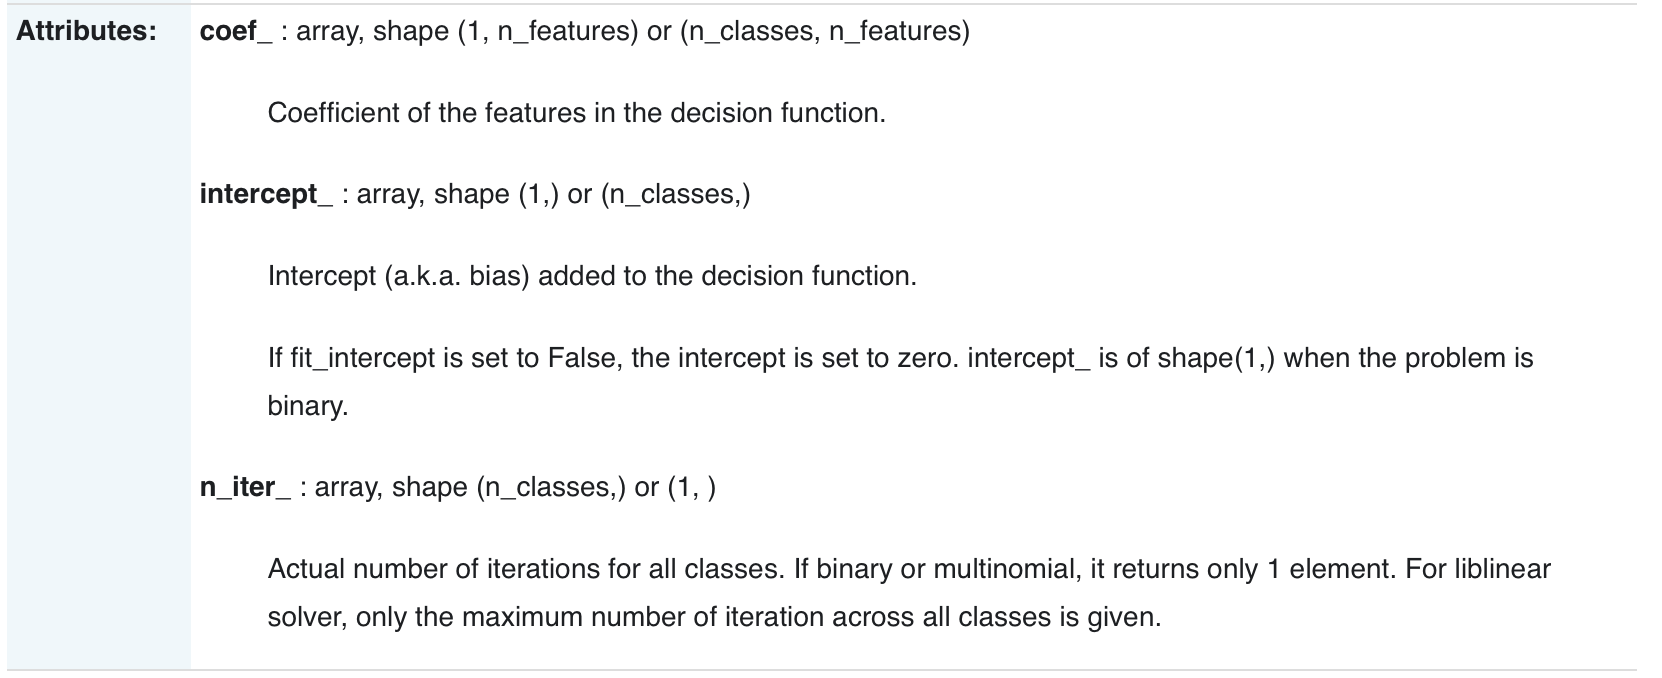

In [64]:
Image(filename='img/lg2.png', width='100%')


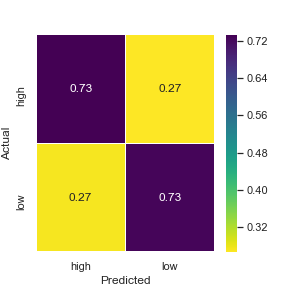

In [65]:
lr_model = LogisticRegression(class_weight="balanced")
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
HTML(evaluate_classification(y_test, lr_pred, pos_label="high",
sample_weight=compute_sample_weight('balanced', y=y_test)))

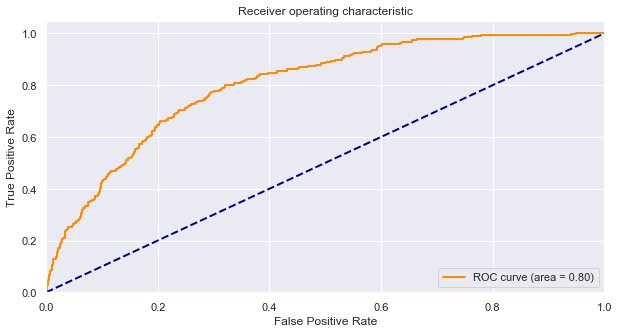

In [66]:
plot_roc_single(y_test, lr_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

## Decision Tree

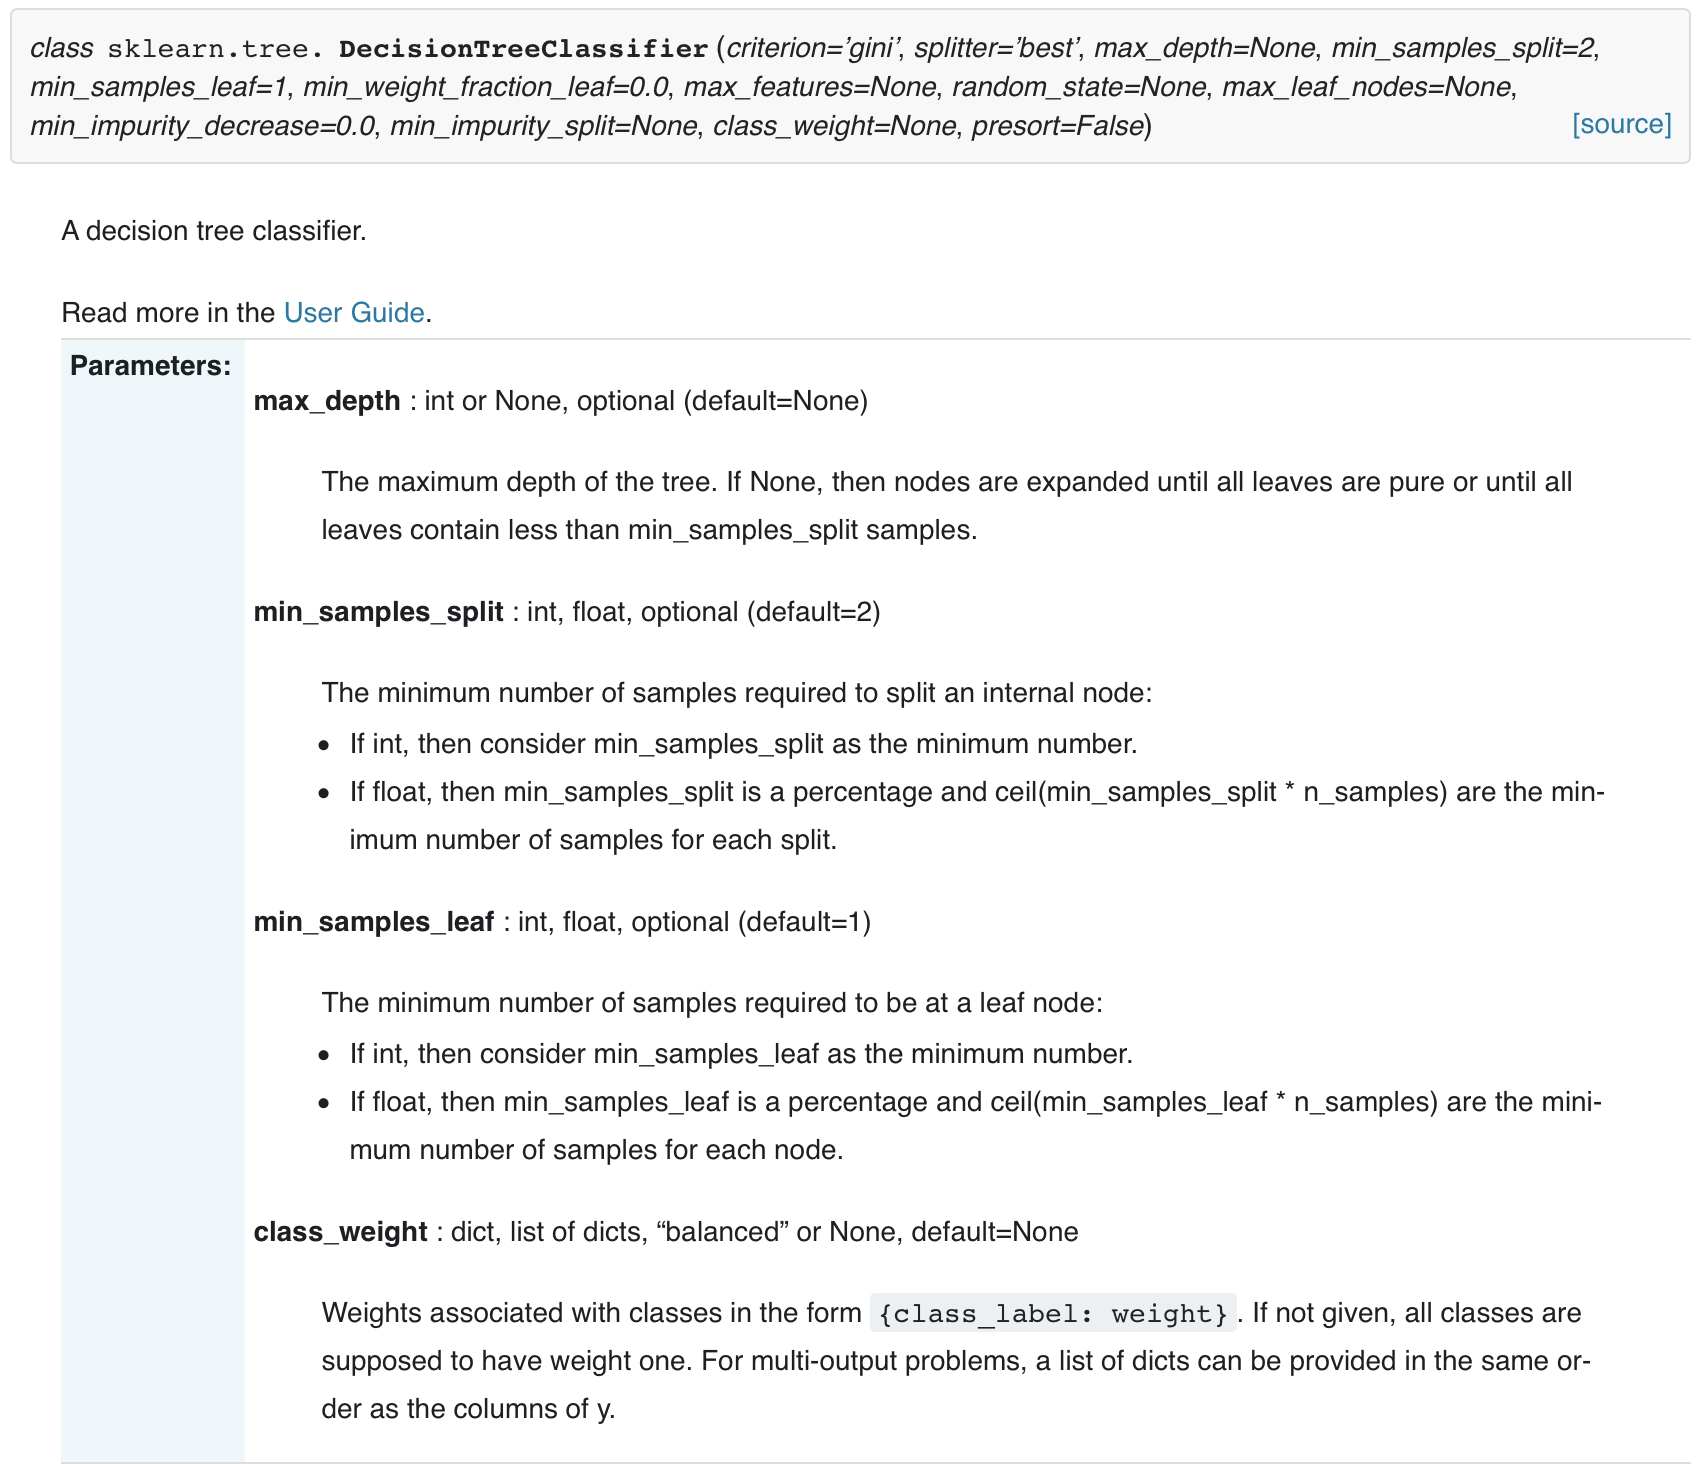

In [67]:
Image(filename='img/df1.png', width='100%')

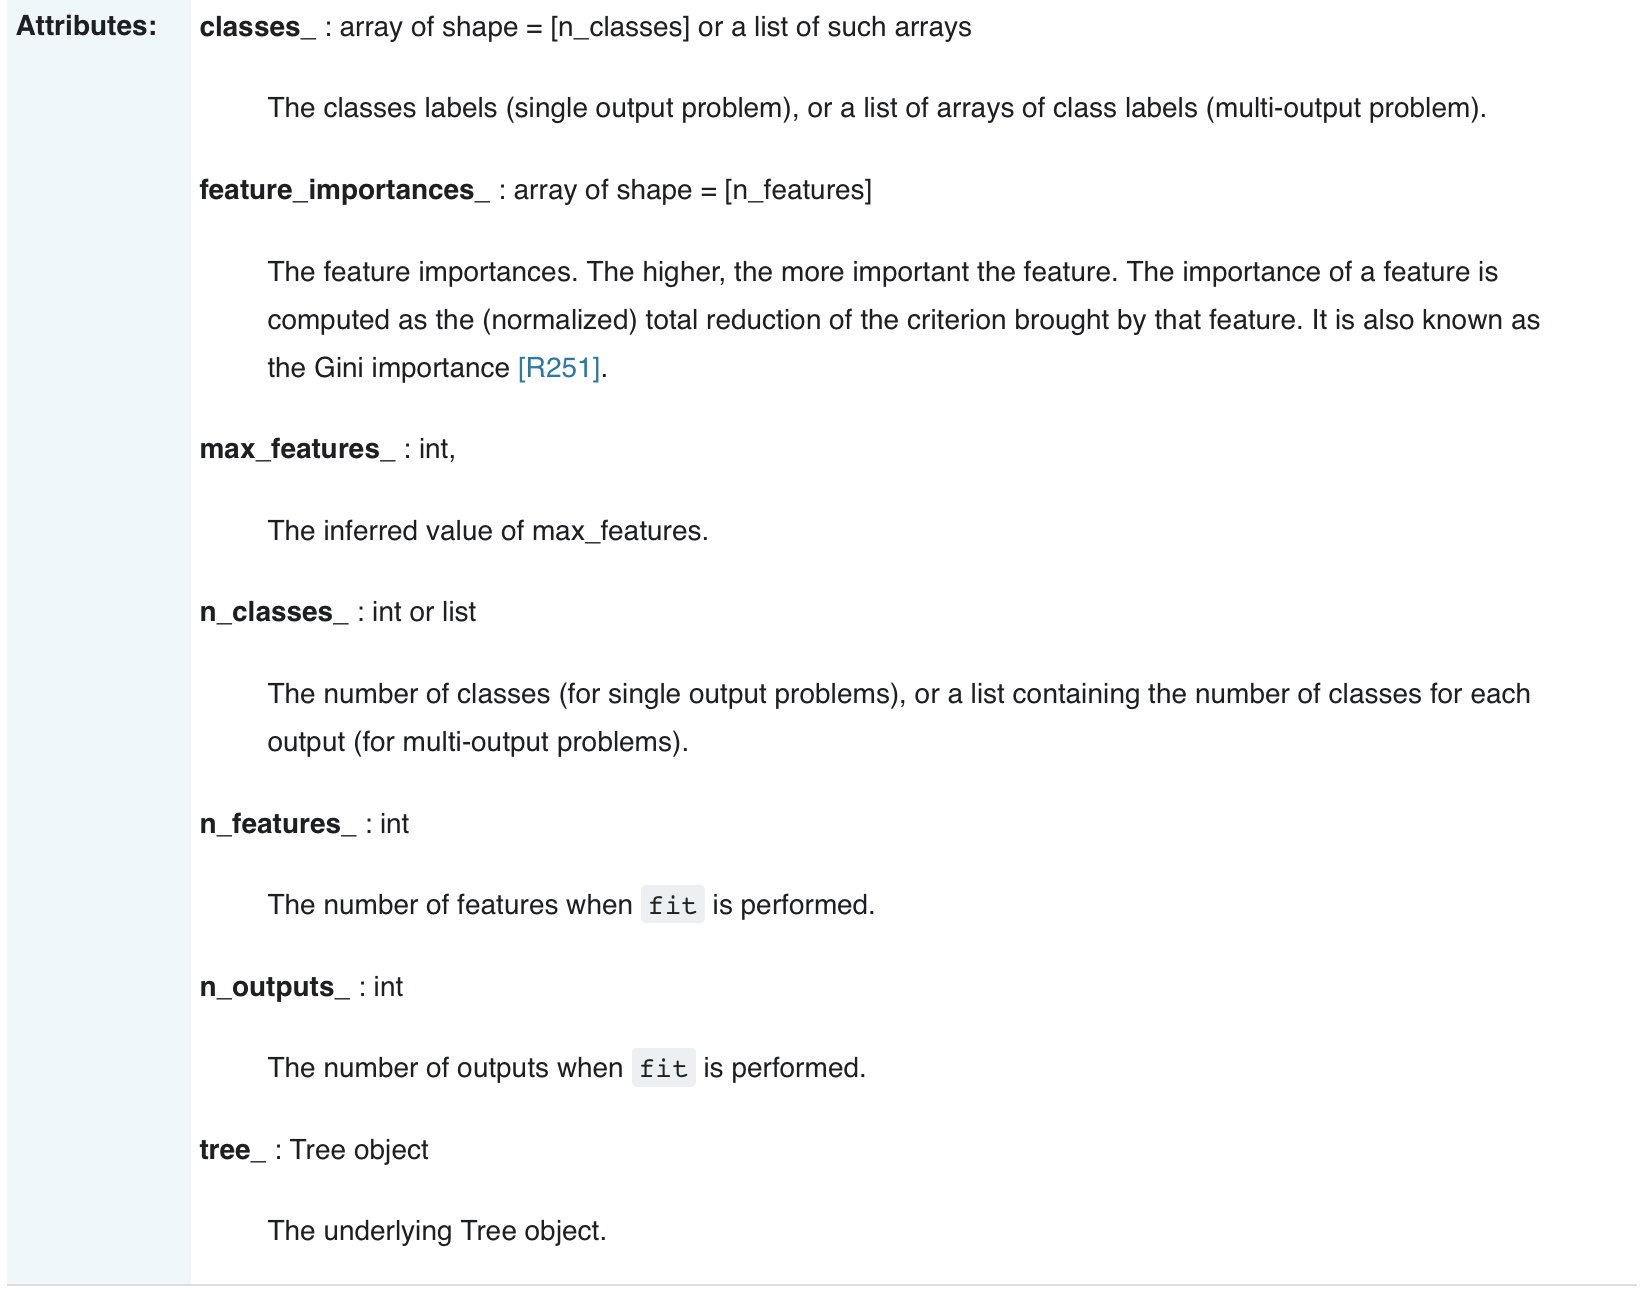

In [68]:
Image(filename='img/df2.png', width='100%')


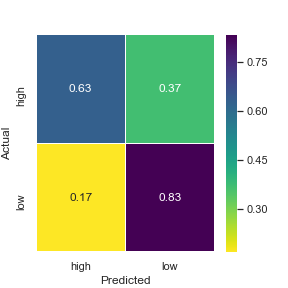

In [69]:
dt_model = DecisionTreeClassifier(class_weight="balanced", min_samples_leaf=3)
#sw=compute_sample_weight('balanced', y=y_train)
#sw[sw>1]=sw[sw>1]**15
sw1=compute_sample_weight('balanced', y=y_test)

dt_model.fit(X_train, y_train)#, sample_weight=sw)
dt_pred = dt_model.predict(X_test)
HTML(evaluate_classification(y_test, dt_pred, pos_label="high", sample_weight=sw1))

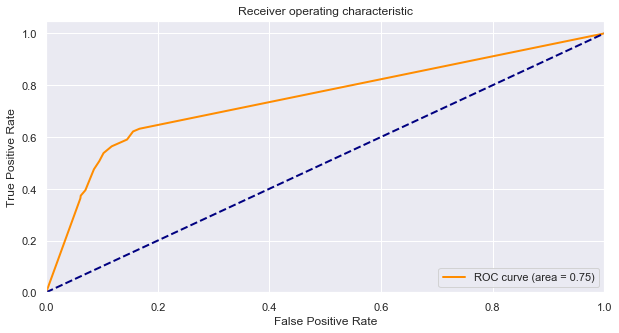

In [70]:
plot_roc_single(y_test, dt_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

## K-NN

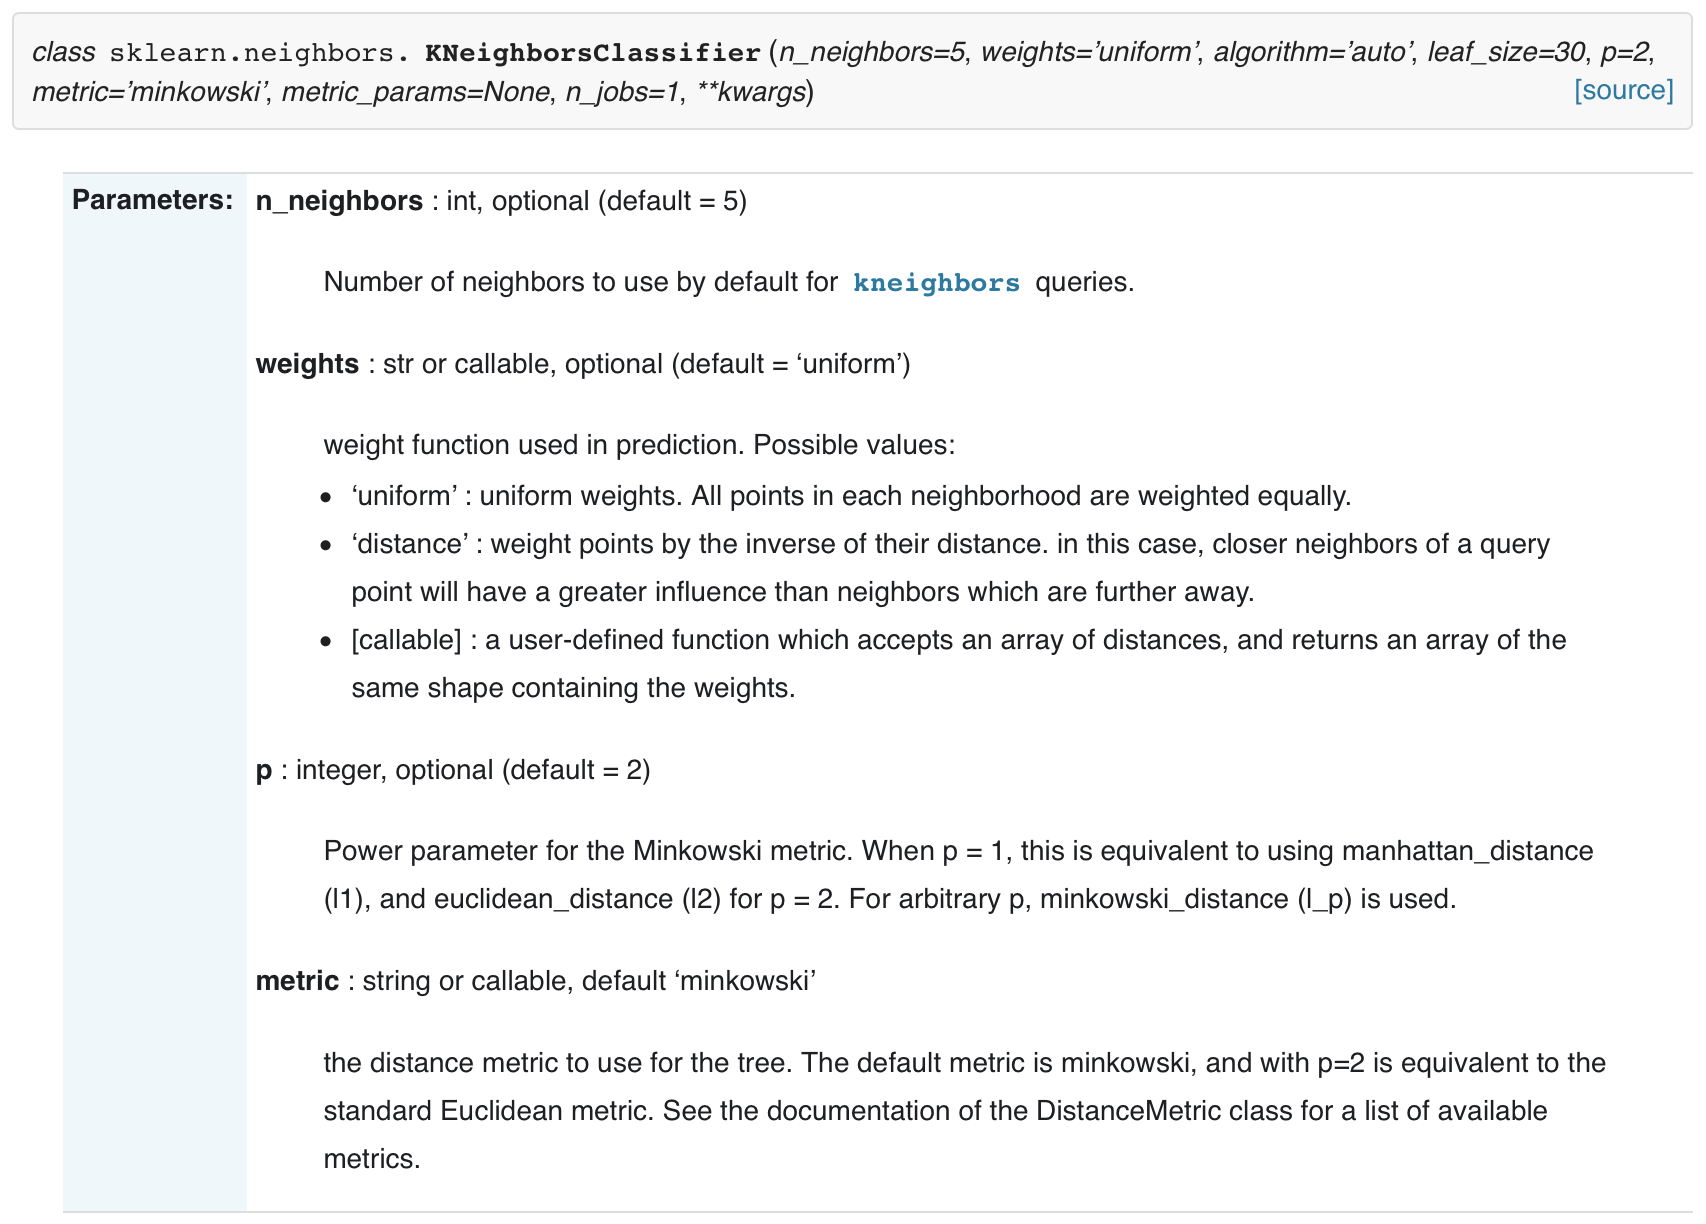

In [71]:
Image(filename='img/knn.png', width='100%')


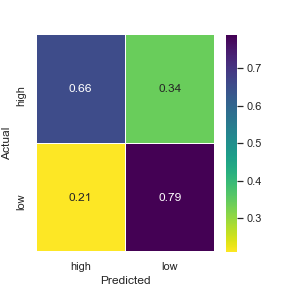

In [72]:
knn_model = KNeighborsClassifier(n_neighbors=2,  algorithm="brute" )
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
sw1=compute_sample_weight('balanced', y=y_test)
HTML(evaluate_classification(y_test, knn_pred, pos_label="high", sample_weight=sw1))

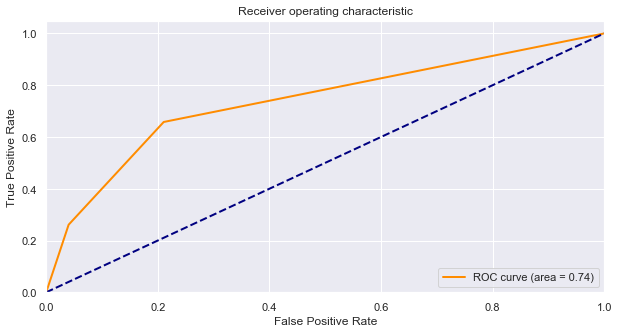

In [73]:
plot_roc_single(y_test, knn_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

## 5.2. Multi-class

In [138]:
def convert_to_multiclass(x):
    if x == 3 or x == 4 or x == 5 :
        return "low"
    elif  x == 6:
        return "medium"
    else:
        return "high"

df['class'] = df.quality.apply(convert_to_multiclass)

In [139]:
df['class'].value_counts()

medium    2836
low       2384
high      1277
Name: class, dtype: int64

In [141]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), 
                                                df['class'].values)

## Logistic Regression

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



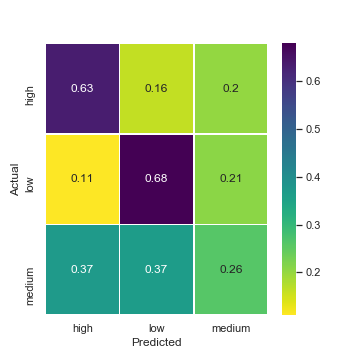

In [142]:
lr_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", class_weight="balanced", max_iter=100)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
HTML(evaluate_classification(y_test, lr_pred, average="macro", fs=5))

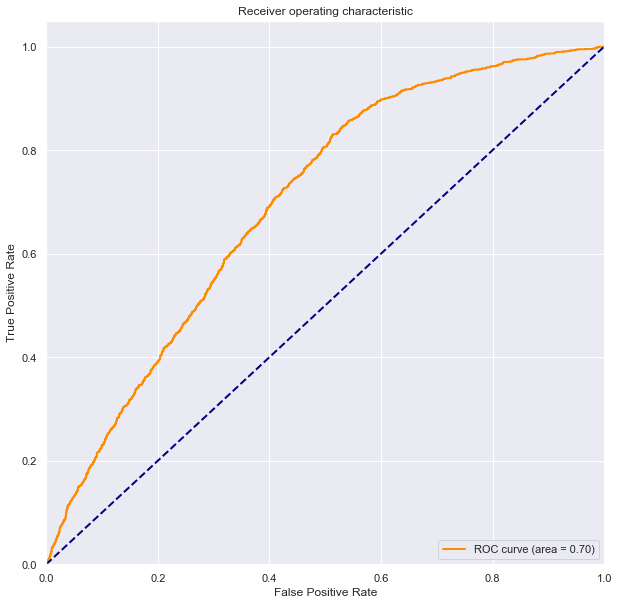

In [143]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), lr_model.decision_function(X_test), fsize=[10,10])

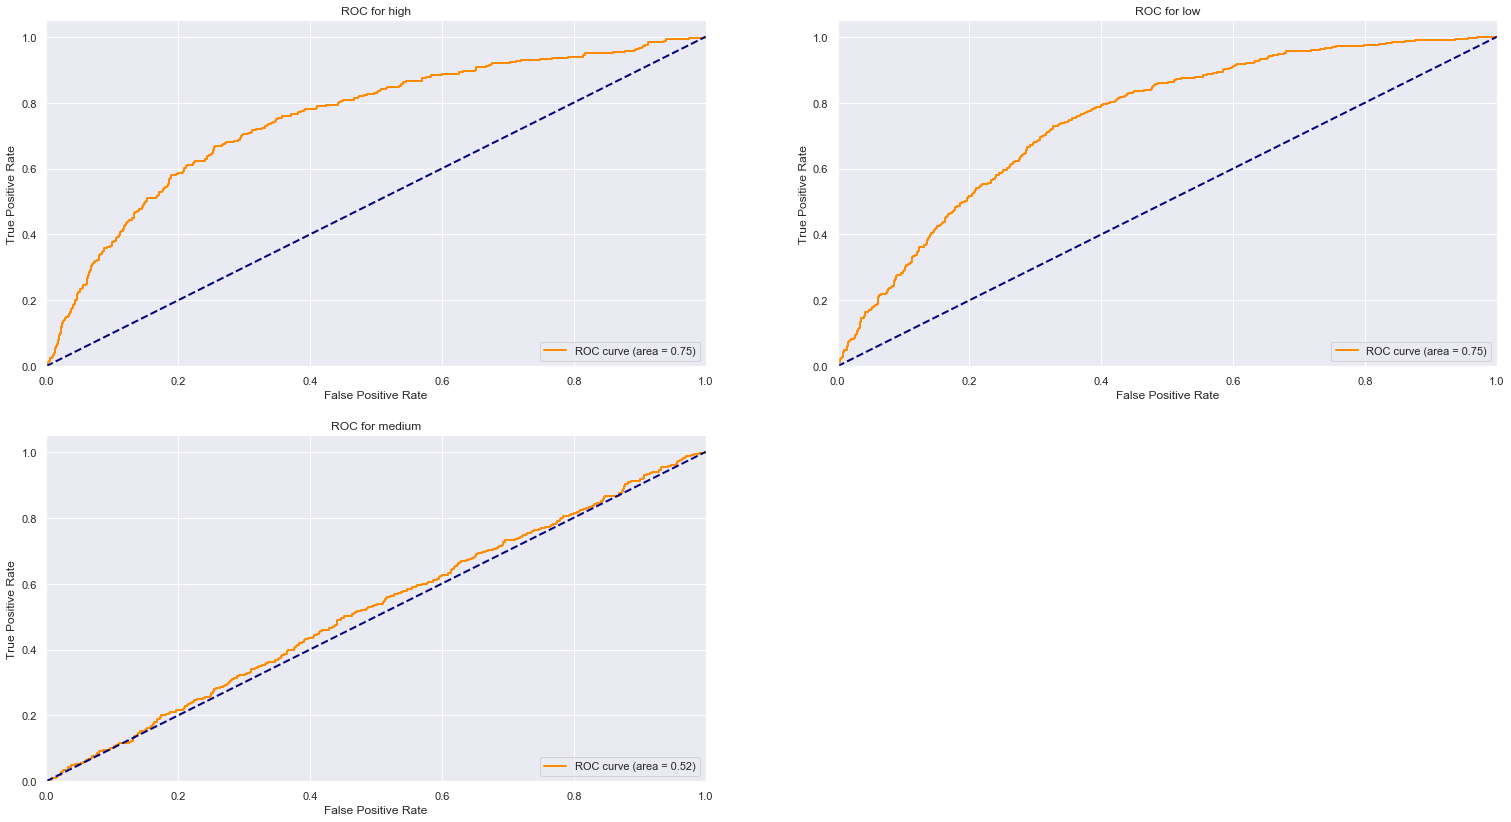

In [144]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), lr_model.decision_function(X_test), titles=np.unique(y_test))

### Decision Tree


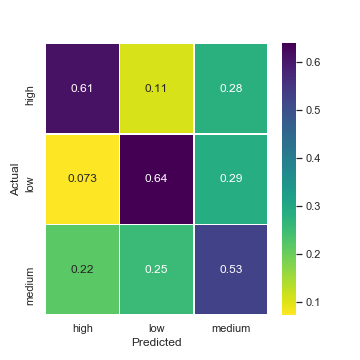

In [145]:
dt_model = DecisionTreeClassifier(class_weight="balanced", 
                                  min_samples_leaf=3, 
                                  criterion='gini')
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
HTML(evaluate_classification(y_test, dt_pred, average="micro", fs=5))

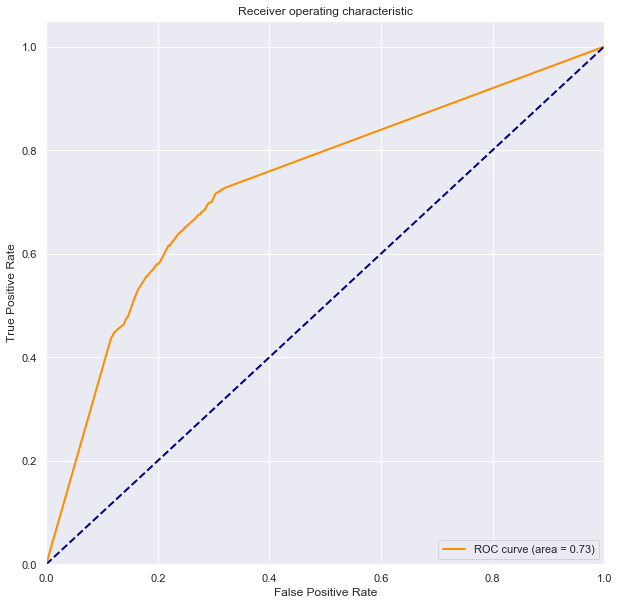

In [146]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), dt_model.predict_proba(X_test), fsize=[10,10])

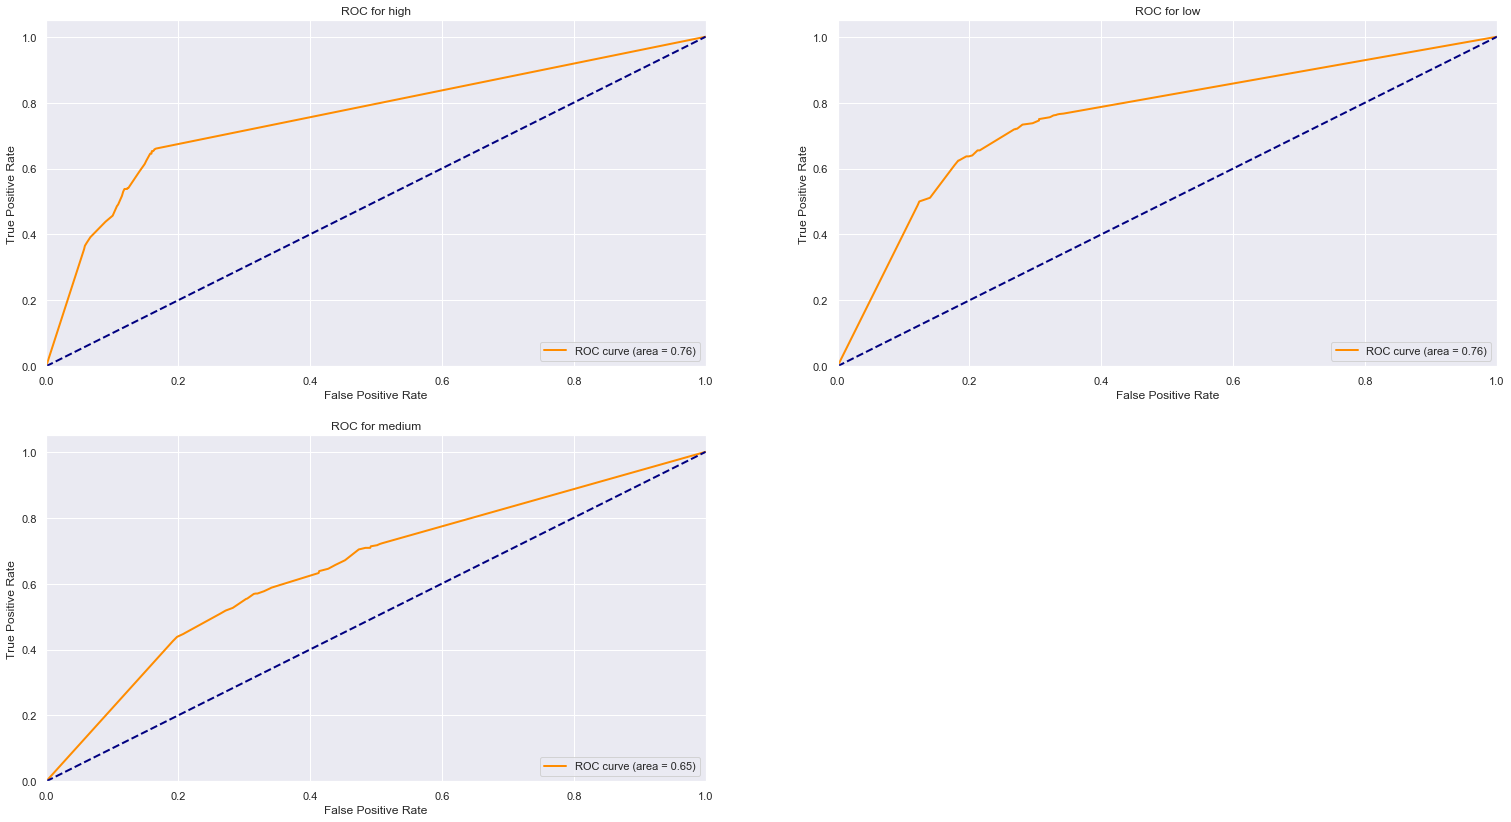

In [147]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), dt_model.predict_proba(X_test), titles=np.unique(y_test))

### K-NN


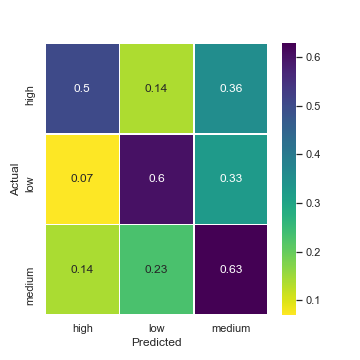

In [148]:
knn_model = KNeighborsClassifier(n_neighbors=5, 
                                 algorithm='brute', 
                                 weights='distance', 
                                 metric='cosine')
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
HTML(evaluate_classification(y_test, knn_pred, average="macro", fs=5))

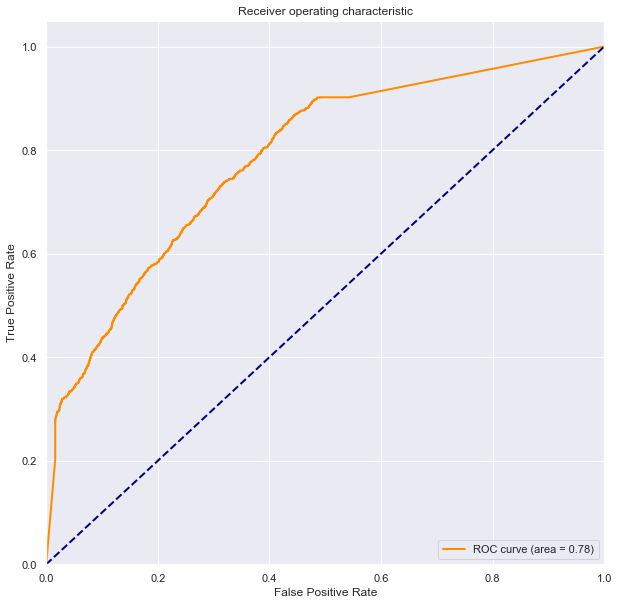

In [149]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), knn_model.predict_proba(X_test), fsize=[10,10])

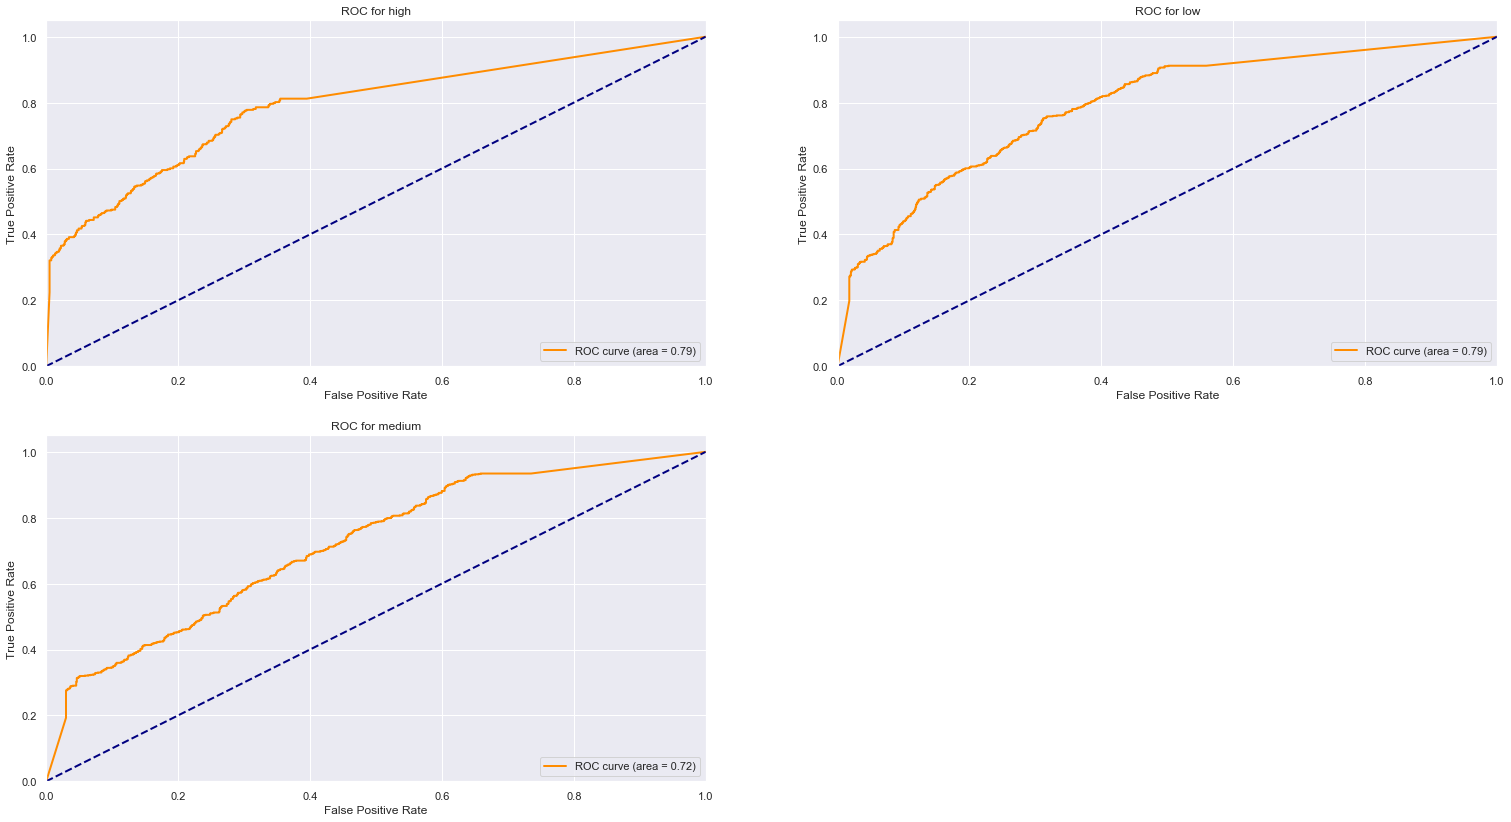

In [150]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), knn_model.predict_proba(X_test), titles=np.unique(y_test))

## Ensemble

Ensembling approaches train several classifiers in the hope that combining their predictions will outperform any single classifier (worst case scenario, be better than the worse classifier). The combination rule can be: majority vote, mean, max, min, product … the average rule is the most used. You can read more https://mlwave.com/kaggle-ensembling-guide/

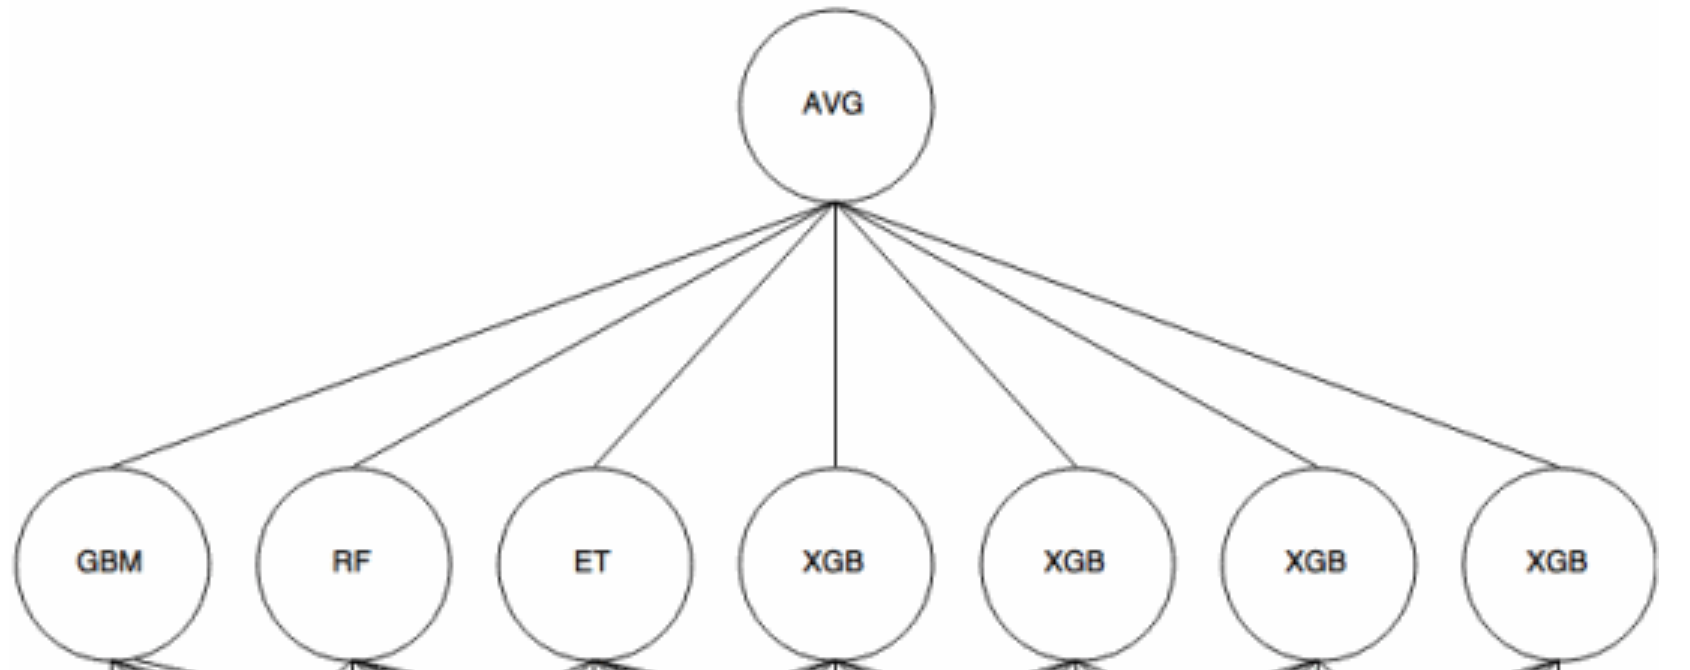

In [151]:
Image(filename='img/ensemble.png', width='100%')

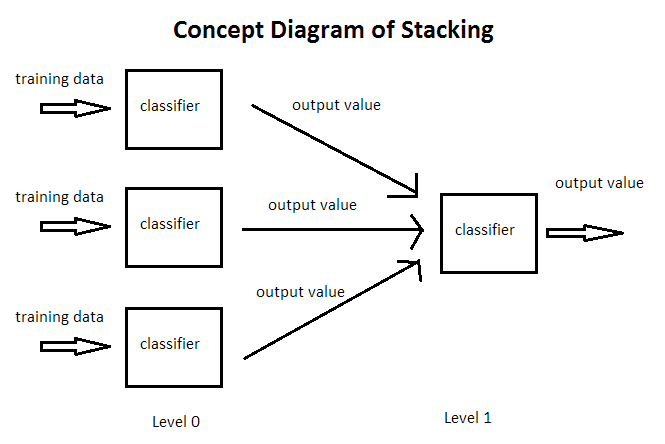

In [152]:
Image(filename='img/ensemble_stack.png', width='100%')

In [153]:
def f(x):
    dc=np.array(['high','low','medium'])
    pred_pr=dt_pred*x[0]+knn_pred*x[1]+lr_pred*x[2]
    pred=pred_pr.argmax(axis=1)
    m=np.array(confusion_matrix_simple(y_test,pred))
    return (1-m.diagonal().min())
def opt():
    acc=[]
    X=[]
    for k in range(20):
        x0=k/20.0
        for k1 in range(20-k-1):
            x1=k1/20.0
            x2=1-x0-x1
            acc.append(f([x0,x1,x2]))
            X.append([x0,x1,x2])
            
    return(acc, X)
    

Best coefficients: [0.25, 0.35, 0.4]



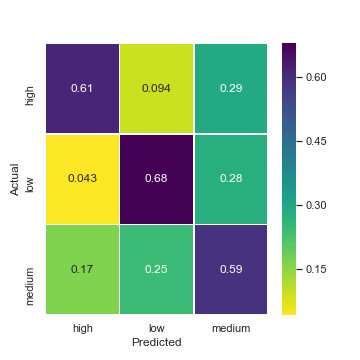

In [154]:
dc=np.array(['high','low','medium'])

knn_pred = knn_model.predict_proba(X_test)
dt_pred=dt_model.predict_proba(X_test)
lr_pred = lr_model.predict_proba(X_test)

res, coeff =opt()
res=np.array(res)
cf=coeff[res.argmin()]
pred_pr=(dt_pred*cf[0]+knn_pred*cf[1]+lr_pred*cf[2])
pred=pred_pr.argmax(axis=1)

pred=dc[pred]
print('Best coefficients:', cf)
HTML(evaluate_classification(y_test, pred, average="macro", fs=5))

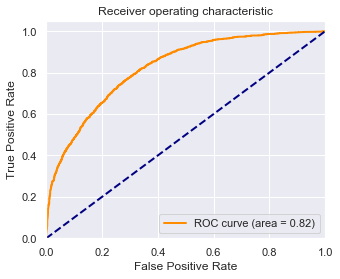

In [155]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), pred_pr, fsize=[5,4])

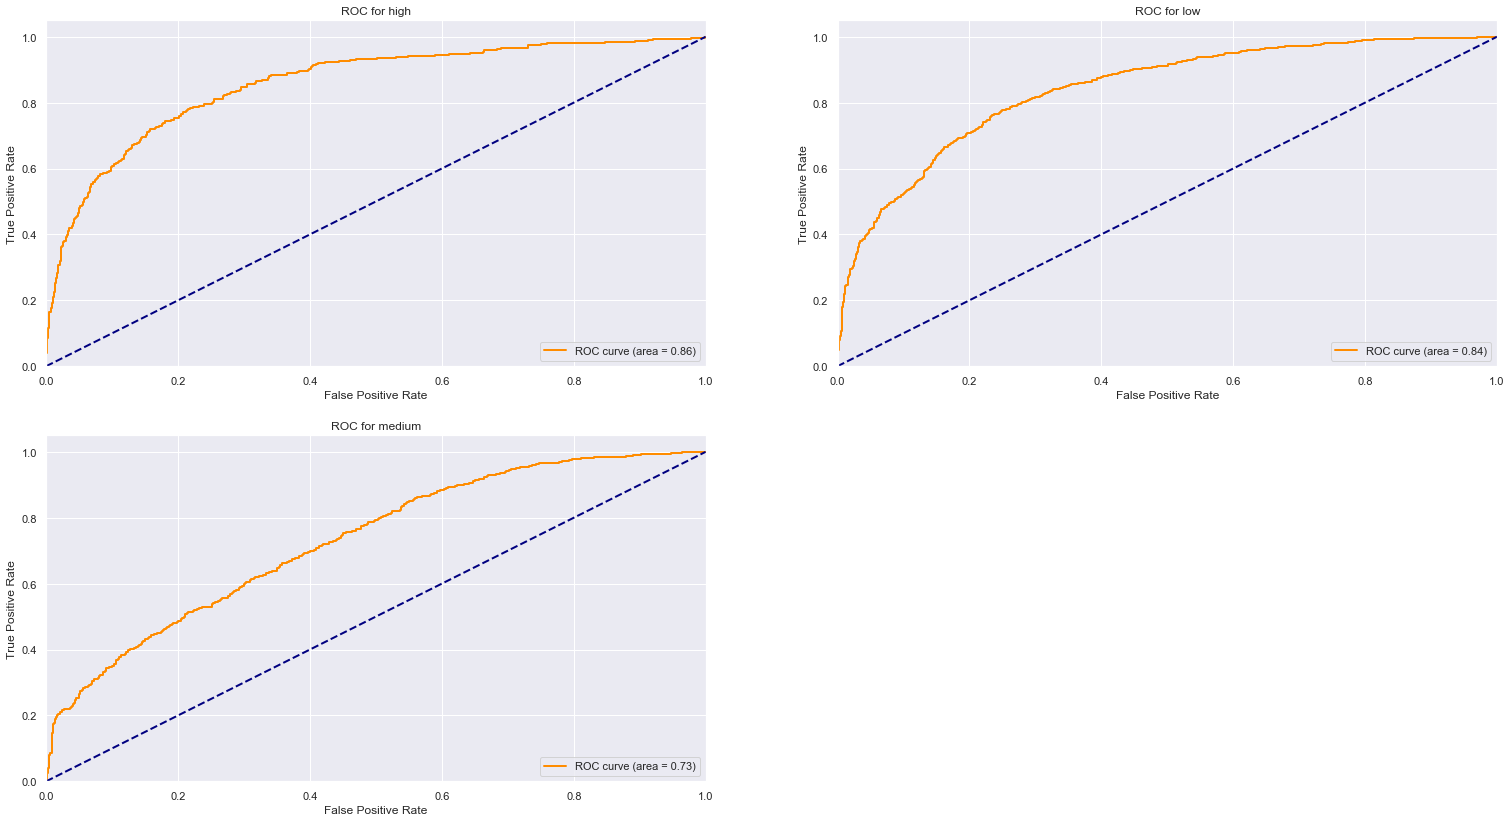

In [156]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), pred_pr, titles=np.unique(y_test))

## Tuning parameters in KNN model

In [157]:
from sklearn.model_selection import GridSearchCV

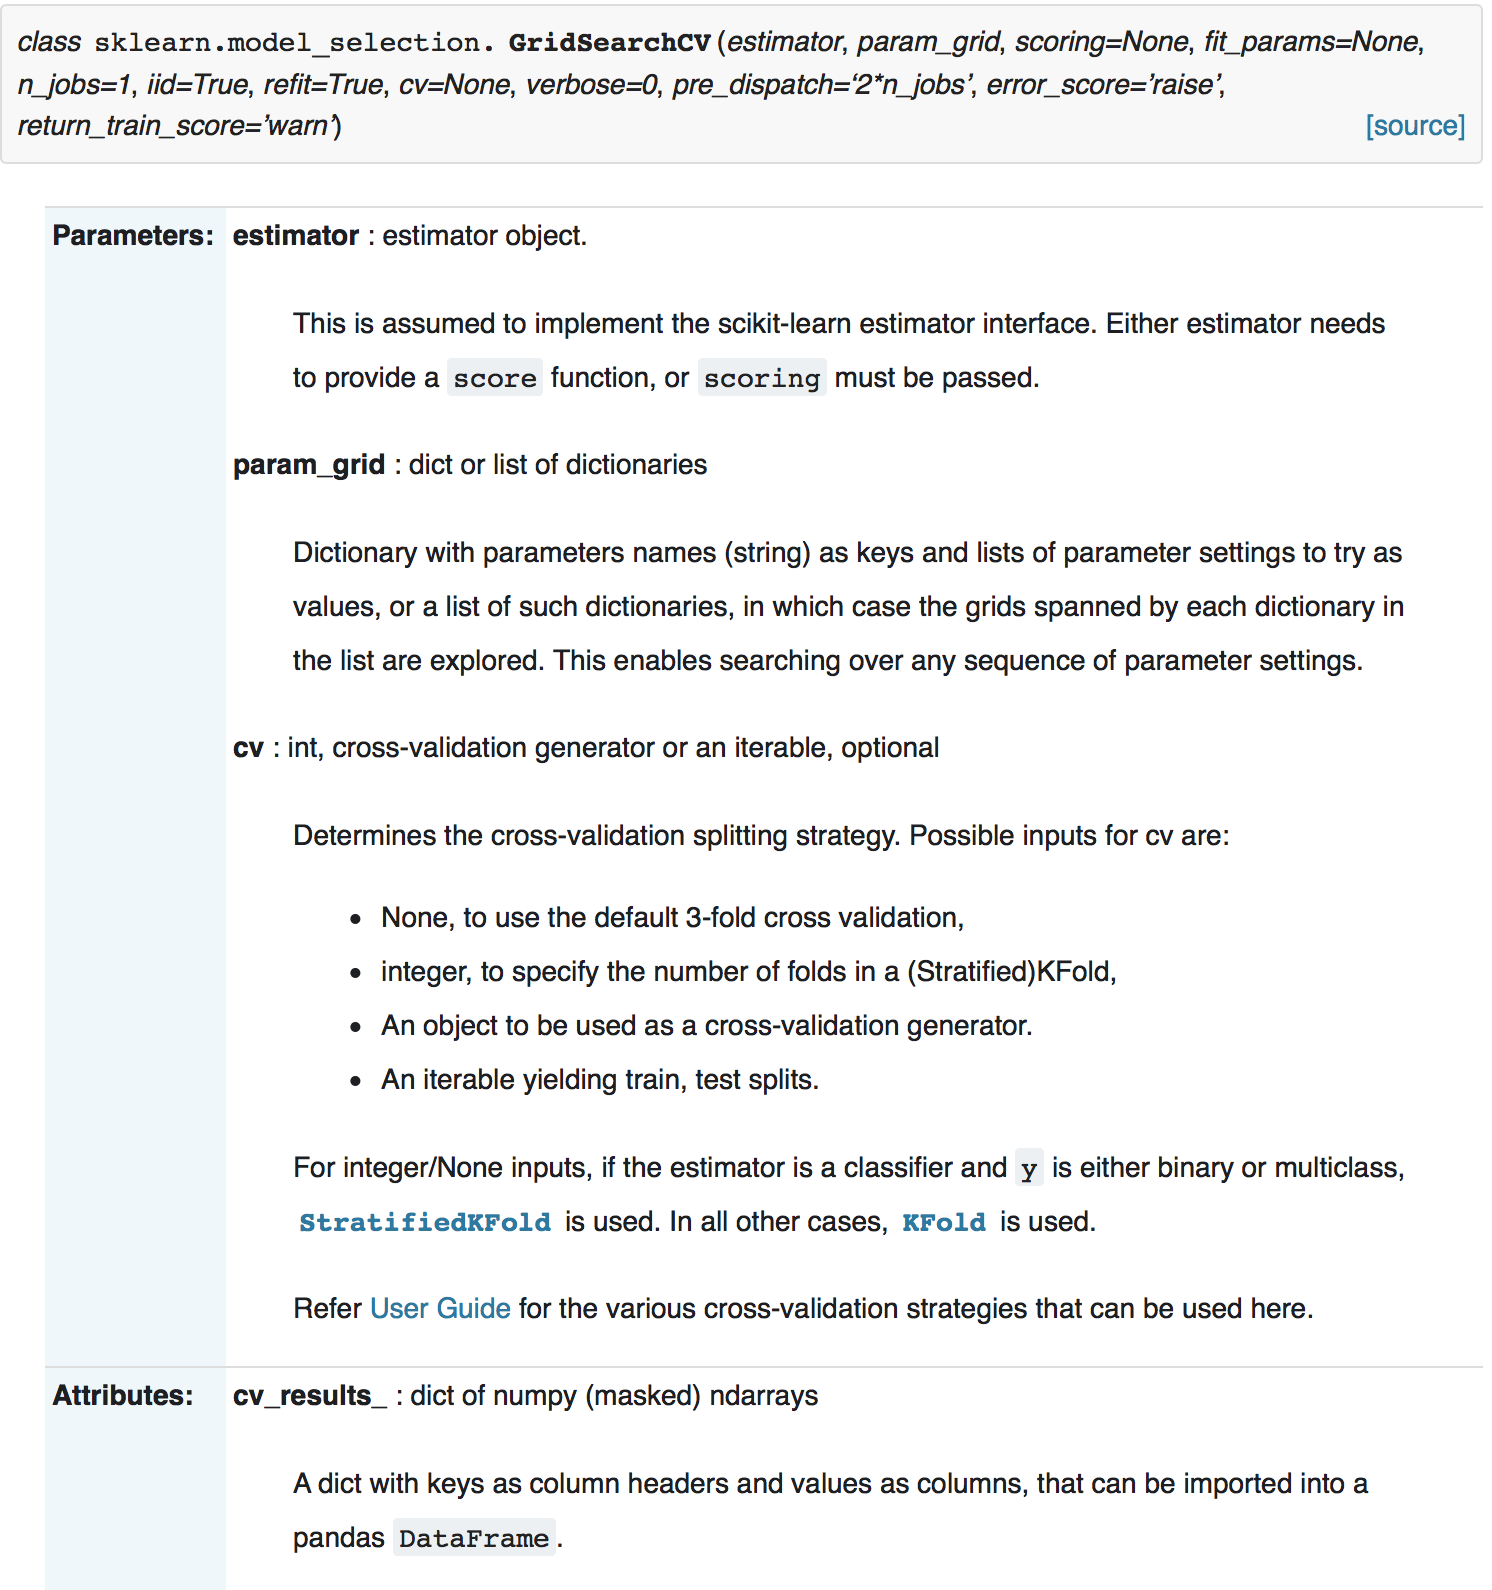

In [158]:
Image(filename='img/gs_cv.png', width='100%')


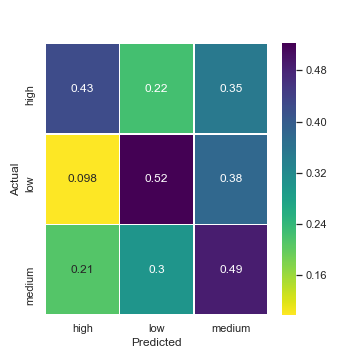

In [159]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
HTML(evaluate_classification(y_test, knn_pred, average="macro", fs=5))

In [160]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['class'].values)

knn_params = {'weights': ["uniform", 'distance'],
            'metric': ['cosine','minkowski'],
            'n_neighbors': np.arange(2, 8, 1),
            'algorithm' : ['auto', 'brute']
    }

clf_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, verbose=1)
clf_knn.fit(X_train, y_train)
print('Best parameters:', clf_knn.best_params_)
knn_tune_pred = clf_knn.predict(X_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 4, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   10.0s finished



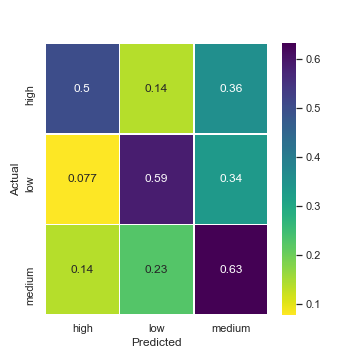

In [161]:
HTML(evaluate_classification(y_test, knn_tune_pred, average="macro", fs=5))

## Tuning parameters in DecisionTree model


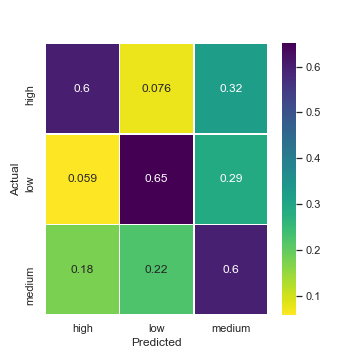

In [162]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
HTML(evaluate_classification(y_test, dt_pred, average="micro", fs=5))

In [163]:
tree_params = {'class_weight': ["balanced"],
            'criterion': ['gini','entropy'],
            'min_samples_leaf': np.arange(2, 7, 1),
            'max_depth': np.arange(50, 700, 50),
            'max_features': ["sqrt", "log2"]
    }
clf_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=3, verbose=1, n_jobs=-1)
clf_tree.fit(X_train, y_train)
print('Best parameters:', clf_tree.best_params_)
dt_tune_pred = clf_tree.predict(X_test)

Fitting 3 folds for each of 260 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s


Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 300, 'max_features': 'sqrt', 'min_samples_leaf': 2}


[Parallel(n_jobs=-1)]: Done 757 out of 780 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 780 out of 780 | elapsed:    3.1s finished



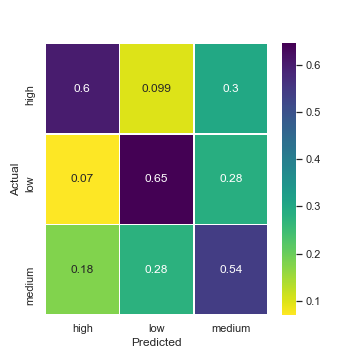

In [164]:
HTML(evaluate_classification(y_test, dt_tune_pred, average="micro", fs=5))

## Tuning XGBoost

In [172]:
class_label_dict = {'high':2, 'low':0, 'medium':1}
y_train_labeled = list(map(class_label_dict.get, y_train))
y_test_labeled = list(map(class_label_dict.get, y_test))

In [192]:
label_class_dict = dict(map(reversed, class_label_dict.items()))

In [193]:
np.unique(y_train), np.unique(y_train_labeled)

(array(['high', 'low', 'medium'], dtype=object), array([0, 1, 2]))

In [197]:
import numpy as np
import pandas as pd
from hyperopt.pyll import scope

from sklearn.model_selection import (cross_val_score, train_test_split,
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb

import os
import logging
# Let OpenMP use 4 threads to evaluate models - may run into errors
# if this is not set. Should be set before hyperopt import.
os.environ['OMP_NUM_THREADS'] = '32'

import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# -----------------------------------------------------
#                       SETUP
# -----------------------------------------------------

SEED = 42  # Fix the random state to the ultimate answer in life.
# Initialize logger
#logging.basicConfig(filename="xgb_hyperopt.log", level=print)




# -----------------------------------------------------
#                       HYPEROPT
# -----------------------------------------------------

def score(params):
    print("Training with params: ")
    print(params)
    # Delete 'n_estimators' because it's only a constructor param
    # when you're using  XGB's sklearn API.
    # Instead, we have to save 'n_estimators' (# of boosting rounds)
    # to xgb.cv().
    
    num_boost_round = int(params['n_estimators'])
    del params['n_estimators']

    
    
    dtrain = xgb.DMatrix(X_train, label=y_train_labeled)
    # As of version 0.6, XGBoost returns a dataframe of the following form:
    # boosting iter | mean_test_err | mean_test_std | mean_train_err | mean_train_std
    # boost iter 1 mean_test_iter1 | mean_test_std1 | ... | ...
    # boost iter 2 mean_test_iter2 | mean_test_std2 | ... | ...
    # ...
    # boost iter n_estimators

    score_history = xgb.cv(params, dtrain, num_boost_round,
                           nfold=5, #stratified=True,
                           early_stopping_rounds=30,
                           verbose_eval=50)
    # Only use scores from the final boosting round since that's the one
    # that performed the best.
    print(score_history.tail(5))
    mean_final_round = score_history.tail(1)['test-merror-mean'].values[0]
    std_final_round = score_history.tail(1)['test-merror-std'].values[0]
    print("\tMean Score: {0}\n".format(mean_final_round))
    print("\tStd Dev: {0}\n\n".format(std_final_round))
    # score() needs to return the loss (1 - score)
    # since optimize() should be finding the minimum, and AUC
    # naturally finds the maximum.
    #loss = 1 - mean_final_round
    return {'loss': mean_final_round, 'status': STATUS_OK}


def optimize(
    # trials,
        random_state=SEED):
    """
    This is the optimization function that given a space (space here) of
    hyperparameters and a scoring function (score here),
    finds the best hyperparameters.
    """

    space = {
        'max_depth': scope.int(hp.uniform('max_depth', 3, 11)),
        'min_child_weight': scope.int(hp.loguniform('min_child_weight', np.log(1), np.log(100))),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.5)) - 0.0001,
        'gamma': hp.loguniform('gamma', np.log(0.005), np.log(5)) - 0.0001,
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.5, 1),
        'n_estimators': 5000,
        'eta': hp.quniform('eta', 0.01, 0.1, 0.025),
        'alpha': hp.loguniform('alpha', np.log(0.005), np.log(1)) - 0.0001,
        'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
        #'eval_metric': 'mlogloss',#'rmse',
        'objective': 'multi:softmax',#'reg:linear',
        'num_class':3,
        #'n_gpus':1,
        'booster': 'gbtree',
        'tree_method': 'hist',
        'silent': 1,
        'seed': random_state,
        'predictor': 'cpu_predictor',
    }

    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest,
                # trials=trials,
                max_evals=40)
    return best


best_hyperparams = optimize(
    # trials
)
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

Training with params:                               
{'alpha': 0.11295627149264233, 'booster': 'gbtree', 'colsample_bylevel': 0.9267968897055605, 'colsample_bytree': 0.836532910230594, 'eta': 0.1, 'gamma': 0.9264696530376486, 'lambda': 1.3242571275731736, 'learning_rate': 0.0405330414532595, 'max_depth': 8, 'min_child_weight': 35, 'n_estimators': 5000, 'num_class': 3, 'objective': 'multi:softmax', 'predictor': 'cpu_predictor', 'seed': 42, 'silent': 1, 'subsample': 0.7418272957122279, 'tree_method': 'hist'}
[0]	train-merror:0.396415+0.00450632	test-merror:0.448207+0.0134195

[50]	train-merror:0.313064+0.00366103	test-merror:0.381347+0.0146125

[100]	train-merror:0.278975+0.00253743	test-merror:0.368594+0.0143624

[150]	train-merror:0.256543+0.00325017	test-merror:0.359357+0.014344

[200]	train-merror:0.239278+0.00303852	test-merror:0.356056+0.0140419

     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
182           0.245602          0.001821          0.355399   

{'alpha': 0.014471647630564119, 'booster': 'gbtree', 'colsample_bylevel': 0.9865066140263379, 'colsample_bytree': 0.7182359752124602, 'eta': 0.025, 'gamma': 0.005651559074035304, 'lambda': 2.659591088220616, 'learning_rate': 0.03716685659864736, 'max_depth': 5, 'min_child_weight': 57, 'n_estimators': 5000, 'num_class': 3, 'objective': 'multi:softmax', 'predictor': 'cpu_predictor', 'seed': 42, 'silent': 1, 'subsample': 0.6590981724086187, 'tree_method': 'hist'}
[0]	train-merror:0.437486+0.00871243	test-merror:0.471741+0.0180027

[50]	train-merror:0.370299+0.00636938	test-merror:0.40708+0.0163054

[100]	train-merror:0.346877+0.00253491	test-merror:0.397623+0.012622

[150]	train-merror:0.324995+0.00682612	test-merror:0.387508+0.0125611

[200]	train-merror:0.309105+0.0066105	test-merror:0.380691+0.0136135

[250]	train-merror:0.299098+0.00656808	test-merror:0.379153+0.0109016

[300]	train-merror:0.289751+0.00554185	test-merror:0.377396+0.0127718

[350]	train-merror:0.280844+0.00439458	test-

[100]	train-merror:0.0435452+0.000685899	test-merror:0.322412+0.00527585       

[150]	train-merror:0.0131956+0.00101426	test-merror:0.31713+0.00838905         

     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std    
133           0.020013          0.001645          0.317131         0.007429
134           0.019299          0.001341          0.315812         0.006376
135           0.019024          0.001173          0.316031         0.006864
136           0.019024          0.001428          0.316912         0.006932
137           0.018529          0.001421          0.315372         0.005865
	Mean Score: 0.3153718                                                         

	Std Dev: 0.005864714738160752                                                 


Training with params:                                                          
{'alpha': 0.00506388185915394, 'booster': 'gbtree', 'colsample_bylevel': 0.8166802581260241, 'colsample_bytree': 0.6503391146981785, 'e

[0]	train-merror:0.431548+0.00638758	test-merror:0.459865+0.0114937            

[50]	train-merror:0.33808+0.00406465	test-merror:0.388168+0.0117024            

[100]	train-merror:0.299978+0.00429266	test-merror:0.375854+0.00962817         

[150]	train-merror:0.273477+0.00545155	test-merror:0.374314+0.0113715          

[200]	train-merror:0.249176+0.00440822	test-merror:0.367055+0.0130437          

[250]	train-merror:0.227843+0.00168592	test-merror:0.358479+0.0116393          

[300]	train-merror:0.208379+0.00163659	test-merror:0.35672+0.0115169           

[350]	train-merror:0.19161+0.00244461	test-merror:0.352101+0.0110298           

[400]	train-merror:0.176765+0.00241042	test-merror:0.351003+0.0153124          

[450]	train-merror:0.163569+0.00175626	test-merror:0.347702+0.0117012          

[500]	train-merror:0.151859+0.00207318	test-merror:0.347262+0.00839513         

[550]	train-merror:0.142127+0.00234172	test-merror:0.342864+0.00978891         

[600]	train-merror:0.130911+

	Mean Score: 0.302834                                                         

	Std Dev: 0.008432364413377783                                                


Training with params:                                                         
{'alpha': 0.9714016926927891, 'booster': 'gbtree', 'colsample_bylevel': 0.9747048264767345, 'colsample_bytree': 0.5035139982554582, 'eta': 0.0, 'gamma': 0.015260426650965941, 'lambda': 3.4219863755620774, 'learning_rate': 0.1875704583707282, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 5000, 'num_class': 3, 'objective': 'multi:softmax', 'predictor': 'cpu_predictor', 'seed': 42, 'silent': 1, 'subsample': 0.9897099470609536, 'tree_method': 'hist'}
[0]	train-merror:0.268419+0.00732178	test-merror:0.430617+0.0127777           

[50]	train-merror:0.0128656+0.00199195	test-merror:0.301958+0.00428969        

[100]	train-merror:0.000495+0.000320702	test-merror:0.301736+0.00548508       

    train-merror-mean  train-merror-std  test-merror-mean  

[0]	train-merror:0.288376+0.0033735	test-merror:0.424447+0.0203706             

[50]	train-merror:0.003079+0.00118427	test-merror:0.309431+0.00917354          

    train-merror-mean  train-merror-std  test-merror-mean  test-merror-std     
42           0.007478          0.000990          0.311632         0.011837
43           0.006763          0.000618          0.311193         0.010449
44           0.006158          0.000863          0.311632         0.008037
45           0.005608          0.000480          0.309872         0.008686
46           0.005113          0.000977          0.308333         0.008401
	Mean Score: 0.30833320000000003                                               

	Std Dev: 0.00840076966473907                                                  


Training with params:                                                          
{'alpha': 0.7367635745356874, 'booster': 'gbtree', 'colsample_bylevel': 0.5808894504309845, 'colsample_bytree': 0.5030357866875482, 'eta': 0

	Std Dev: 0.00963406150281387                                                  


Training with params:                                                          
{'alpha': 0.31924957351398586, 'booster': 'gbtree', 'colsample_bylevel': 0.9461382531778253, 'colsample_bytree': 0.6064025166007246, 'eta': 0.05, 'gamma': 0.005070348358731241, 'lambda': 3.1292119839853583, 'learning_rate': 0.024051601994110272, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 5000, 'num_class': 3, 'objective': 'multi:softmax', 'predictor': 'cpu_predictor', 'seed': 42, 'silent': 1, 'subsample': 0.7523399631323515, 'tree_method': 'hist'}
[0]	train-merror:0.3543+0.00644112	test-merror:0.446671+0.0176012              

[50]	train-merror:0.232021+0.00414286	test-merror:0.361338+0.0140874           

[100]	train-merror:0.202991+0.00307389	test-merror:0.354079+0.0139546          

[150]	train-merror:0.17737+0.00276562	test-merror:0.345064+0.0107492           

[200]	train-merror:0.157192+0.00204232	test-merror

[250]	train-merror:0.0021444+0.000561128	test-merror:0.299536+0.00994801

     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
217           0.004344          0.000841          0.300855         0.013712
218           0.004234          0.000730          0.300854         0.012773
219           0.004069          0.000533          0.299535         0.012612
220           0.004014          0.000447          0.299974         0.013940
221           0.004014          0.000447          0.299314         0.013503
	Mean Score: 0.2993144                                               

	Std Dev: 0.013502995439531188                                       


Training with params:                                                
{'alpha': 0.05566626642959203, 'booster': 'gbtree', 'colsample_bylevel': 0.7341943548603054, 'colsample_bytree': 0.850134542925639, 'eta': 0.0, 'gamma': 0.053266547988058244, 'lambda': 1.3919406029007126, 'learning_rate': 0.01192746000827, 'max_depth': 10, 

In [200]:
best_hyperparams = {'alpha': 0.16426074238448307, 'booster': 'gbtree', 'colsample_bylevel': 0.8299820504064188, 
                    'colsample_bytree': 0.7386490996876749, 'eta': 0.07500000000000001, 'gamma': 0.010004769356689302, 
                    'lambda': 2.0053051163711584, 'learning_rate': 0.04970997274271573, 'max_depth': 8, 
                    'min_child_weight': 2, 'n_estimators': 5000, 'num_class': 3, 'objective': 'multi:softmax', 
                    'predictor': 'cpu_predictor', 'seed': 42, 'silent': 1, 'subsample': 0.8125217011455531, 
                    'tree_method': 'hist'}

In [199]:
# !pip3 install hyperopt xgboost

In [205]:
dtrain = xgb.DMatrix(X_train, label=y_train_labeled)
dvalid = xgb.DMatrix(X_test, label=y_test_labeled)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_model = xgb.train(best_hyperparams, dtrain, num_boost_round=5000, evals = watchlist,  
                           early_stopping_rounds=20,
                           verbose_eval=50)

[0]	train-merror:0.285463	valid-merror:0.430256
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 20 rounds.
[50]	train-merror:0.130636	valid-merror:0.351795
[100]	train-merror:0.082252	valid-merror:0.334359
Stopping. Best iteration:
[122]	train-merror:0.069057	valid-merror:0.325641




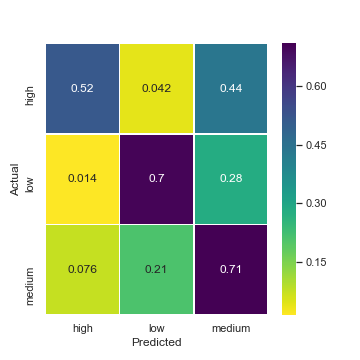

In [206]:
xgb_preds = list(map(label_class_dict.get, xgb_model.predict(dvalid)))

HTML(evaluate_classification(y_test, xgb_preds, average="micro", fs=5))

# 6. Regression

## OLS

In [100]:
X = df.drop(['class', 'color', 'quality'], axis=1).as_matrix()
y = df['quality'].values
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     243.3
Date:                Wed, 10 Jul 2019   Prob (F-statistic):               0.00
Time:                        18:31:14   Log-Likelihood:                -7215.5
No. Observations:                6497   AIC:                         1.445e+04
Df Residuals:                    6485   BIC:                         1.454e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.7627     11.894      4.688      0.0

In [101]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['quality'].values)

## Linear regression

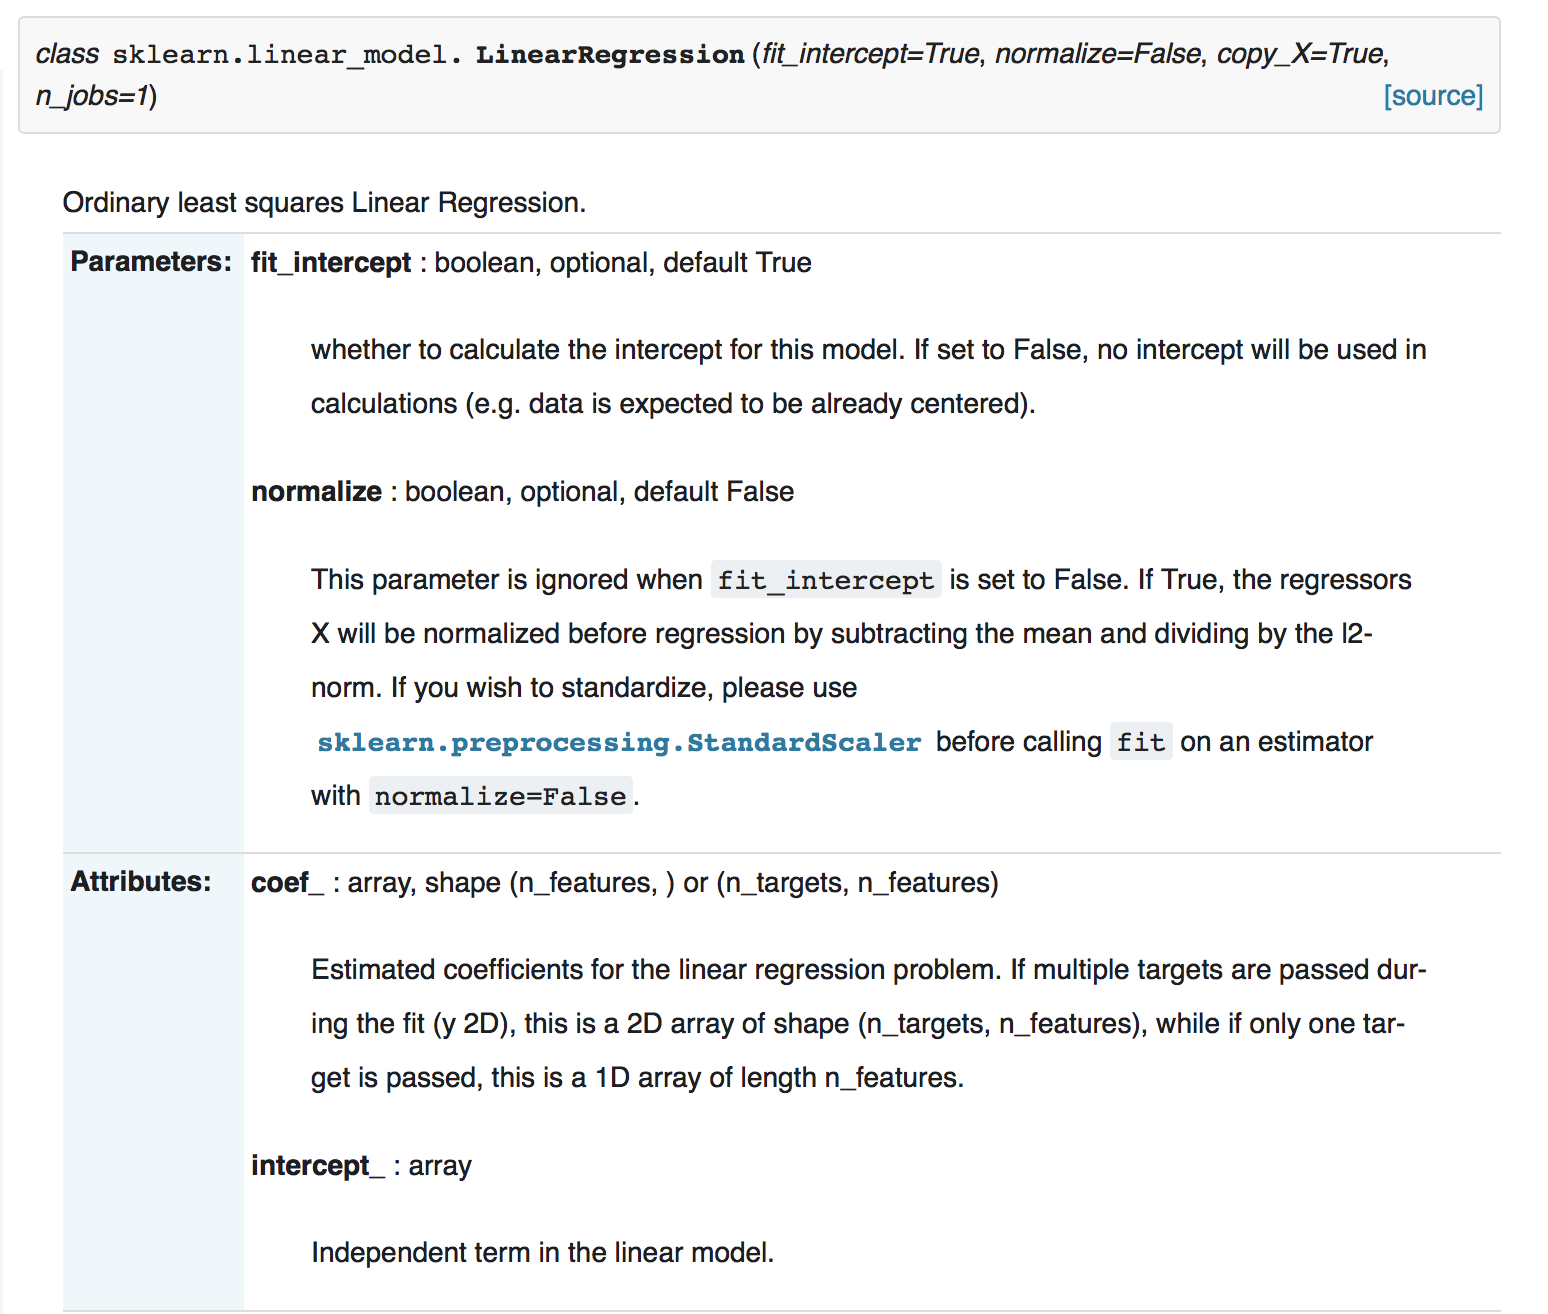

In [102]:
Image(filename='img/lr.png', width='100%')

RMSE: 1.4763514259055592
R^2 score: 0.4550966168066556


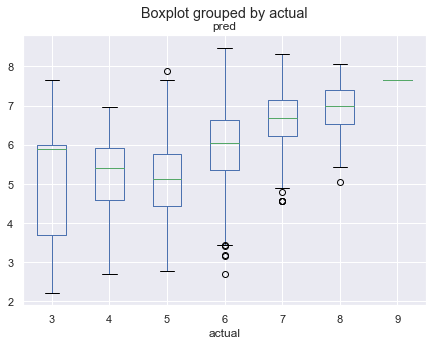

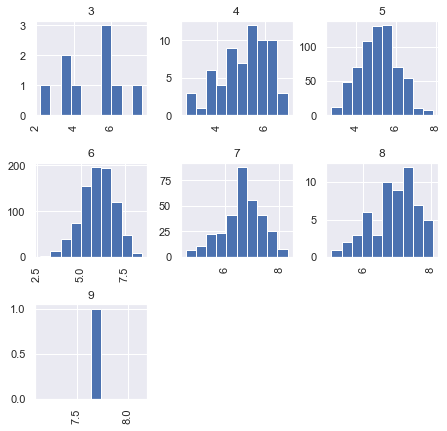

In [103]:
lnr_model = LinearRegression()
sw=compute_sample_weight('balanced', y=y_train)
lnr_model.fit(X_train, y_train, sw)
lnr_pred = lnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, lnr_pred, sample_weight=sw)

## Polynomial regression

RMSE: 1.3122620024151068
R^2 score: 0.5608062697158476


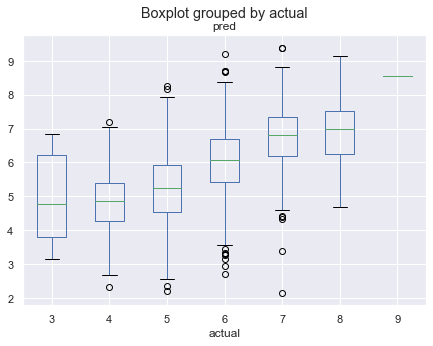

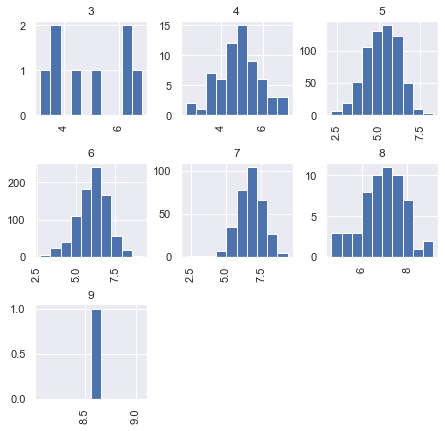

In [104]:
pnr_model = Pipeline([('polynom', PolynomialFeatures(degree=2)), ('linreg', LinearRegression())])
sw=compute_sample_weight('balanced', y=y_train)
pnr_model.fit(X_train, y_train, **{'linreg__sample_weight': sw})
pnr_pred = pnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test[pnr_pred>0], pnr_pred[pnr_pred>0], sample_weight=sw[pnr_pred>0])

## Decision Tree

RMSE: 1.552372805964582
R^2 score: 0.39753466782541247


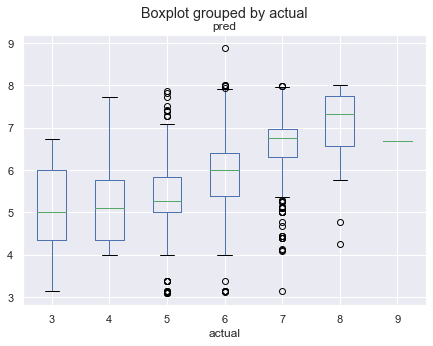

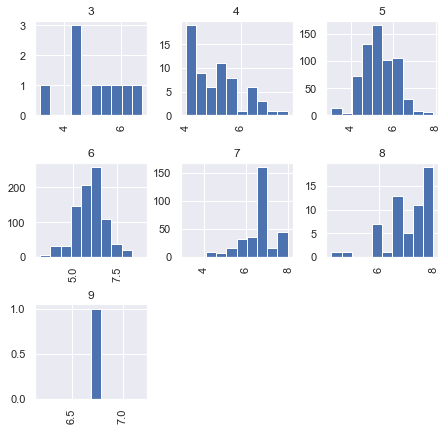

In [105]:
dtr_model = DecisionTreeRegressor(min_samples_leaf=6,random_state=1)
sw=compute_sample_weight('balanced', y=y_train)
dtr_model.fit(X_train, y_train, sample_weight=sw)
dtr_pred = dtr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, dtr_pred, sample_weight=sw)

## K-NN

RMSE: 1.6934978888401444
R^2 score: 0.28301622512349345


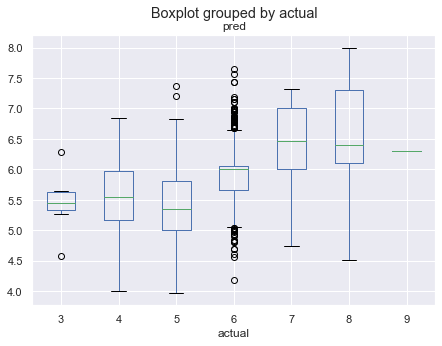

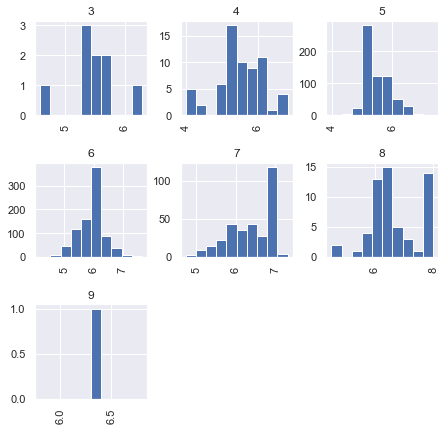

In [106]:
knnr_model = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='brute', metric='cosine')
knnr_model.fit(X_train, y_train)
knnr_pred = knnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, knnr_pred,sample_weight=sw)

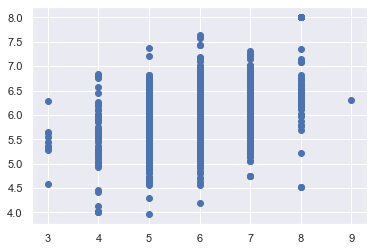

In [107]:
plt.scatter(y_test, knnr_pred)

# 7. Clustering

## Prepare data

In [108]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X = df.drop(['class', 'color', 'quality'], axis=1).as_matrix()
X = StandardScaler().fit_transform(X)

y = df['class'].values
y_labels = le.fit_transform(y)

In [109]:
df['class'].value_counts()

medium    2836
low       2384
high      1277
Name: class, dtype: int64

In [110]:
np.unique(y, return_counts=True), np.unique(y_labels, return_counts=True)

((array(['high', 'low', 'medium'], dtype=object), array([1277, 2384, 2836])),
 (array([0, 1, 2]), array([1277, 2384, 2836])))

## tSNE vizualization

In [111]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000, learning_rate=100)
tsne_results = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6497 samples in 0.003s...
[t-SNE] Computed neighbors for 6497 samples in 0.687s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6497
[t-SNE] Computed conditional probabilities for sample 2000 / 6497
[t-SNE] Computed conditional probabilities for sample 3000 / 6497
[t-SNE] Computed conditional probabilities for sample 4000 / 6497
[t-SNE] Computed conditional probabilities for sample 5000 / 6497
[t-SNE] Computed conditional probabilities for sample 6000 / 6497
[t-SNE] Computed conditional probabilities for sample 6497 / 6497
[t-SNE] Mean sigma: 0.733567
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.775696
[t-SNE] KL divergence after 1000 iterations: 1.433195
t-SNE done! Time elapsed: 54.45743417739868 seconds


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


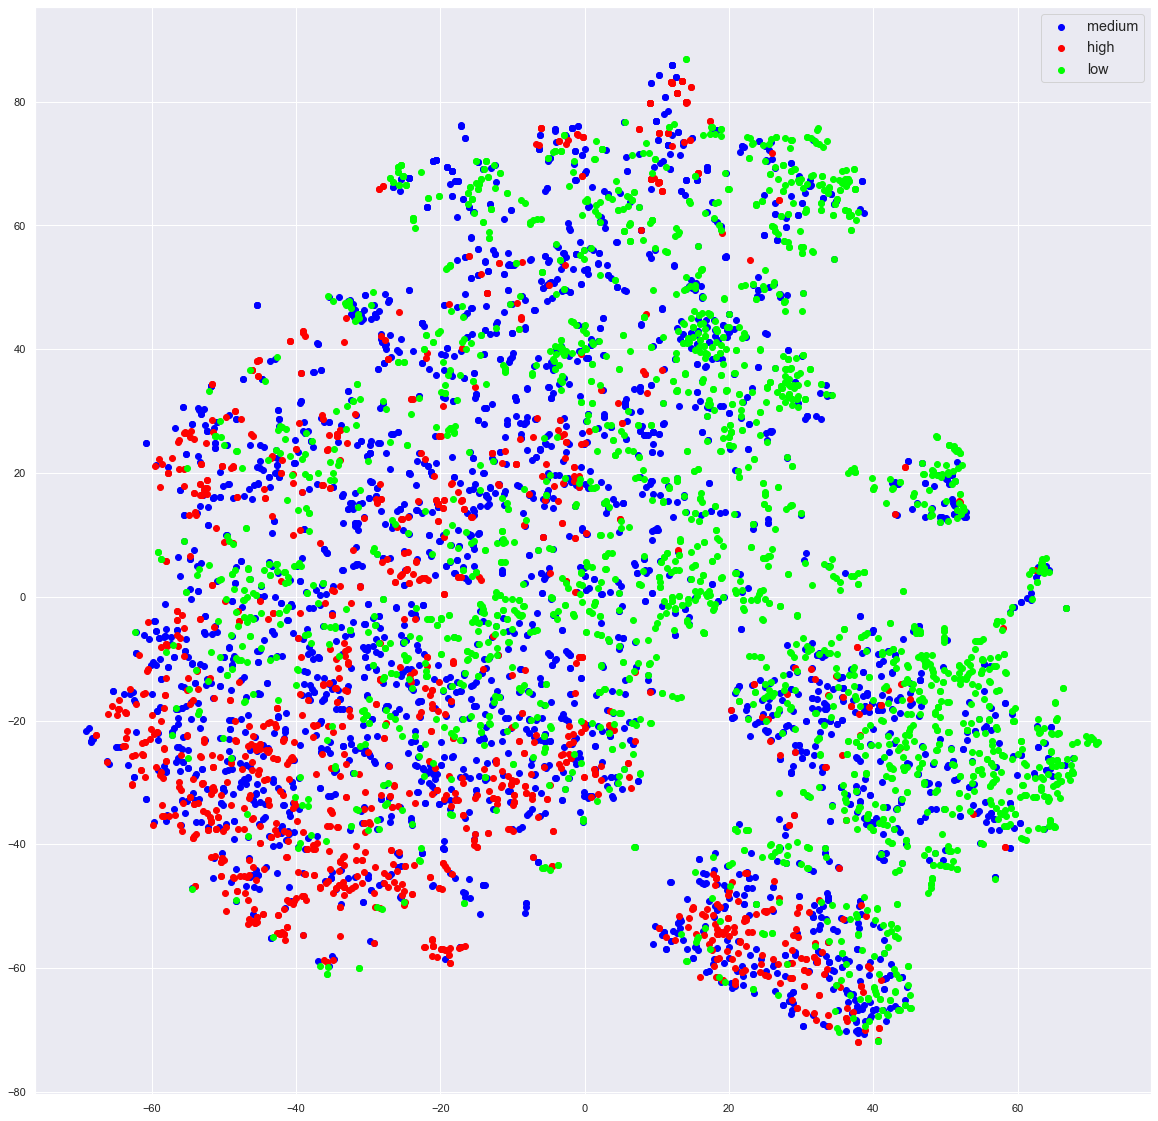

In [112]:
plt.figure(figsize=(20, 20))

unique_labels = list(set(y_labels))
unique = list(set(y))
colors = [plt.cm.brg(float(i)/max(unique_labels)) for i in unique_labels]
for i, u in enumerate(unique):
    #xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    #yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(tsne_results[y == u, 0], 
                tsne_results[y == u, 1], 
                c=colors[i], 
                label=str(u))
plt.legend(fontsize='large')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


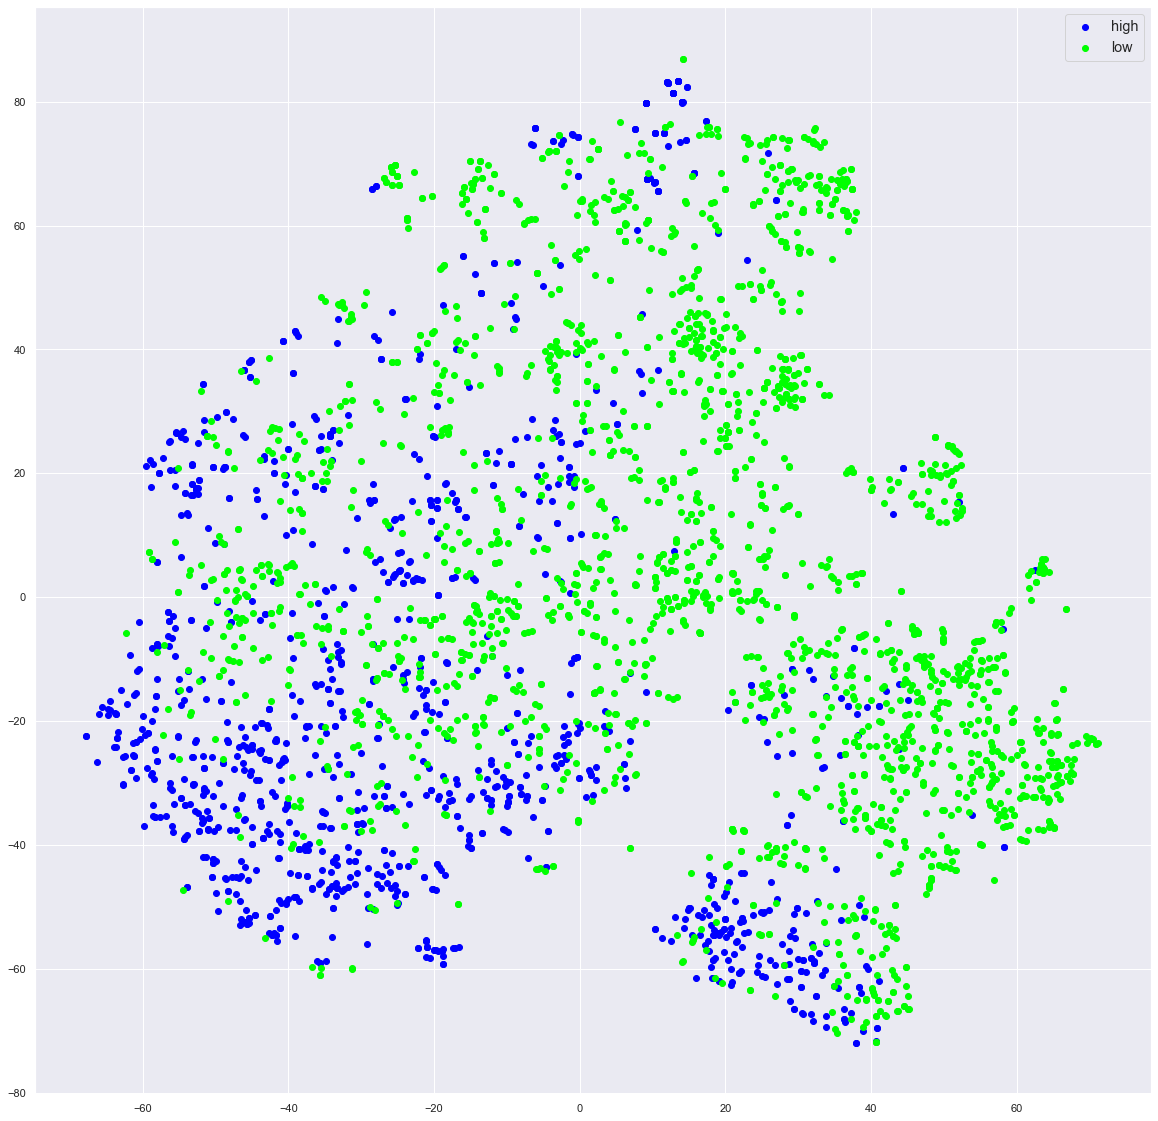

In [113]:
plt.figure(figsize=(20, 20))

unique_labels = [0, 1]
unique = ['high', 'low']
colors = [plt.cm.brg(float(i)/max(unique_labels)) for i in unique_labels]
for i, u in enumerate(unique):
    #xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    #yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(tsne_results[y == u, 0], 
                tsne_results[y == u, 1], 
                c=colors[i], 
                label=str(u))
plt.legend(fontsize='large')
plt.show()

## K-Means

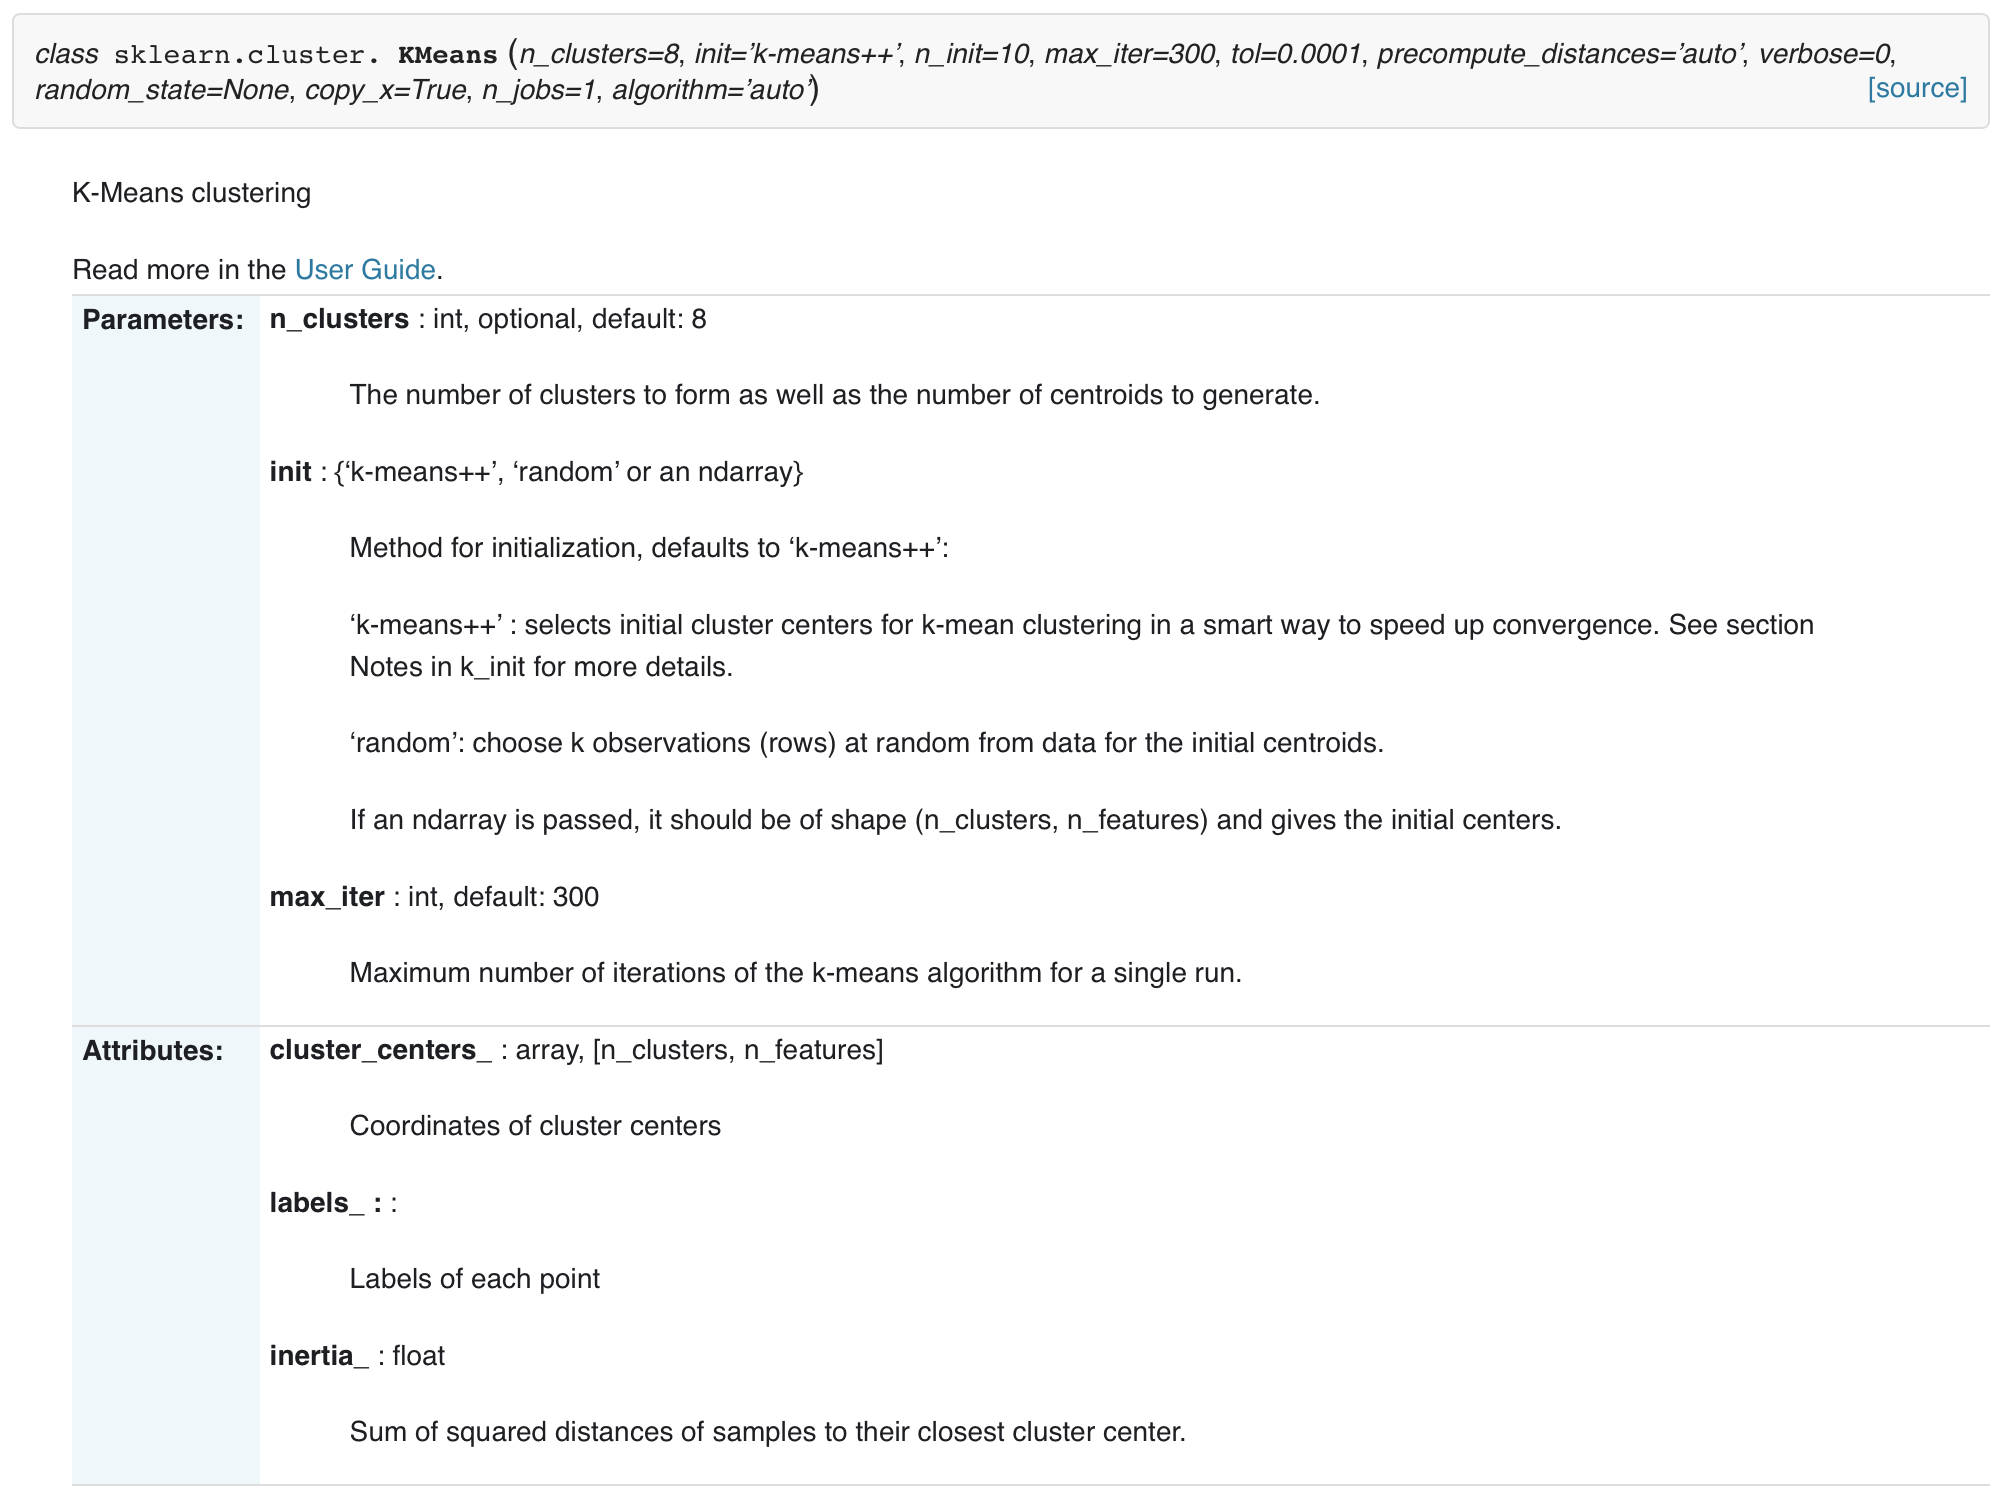

In [114]:
Image(filename='img/kmeans.png', width='100%')

100%|██████████| 18/18 [00:21<00:00,  1.51s/it]


Text(0.5, 1.0, 'Silhouette scores')

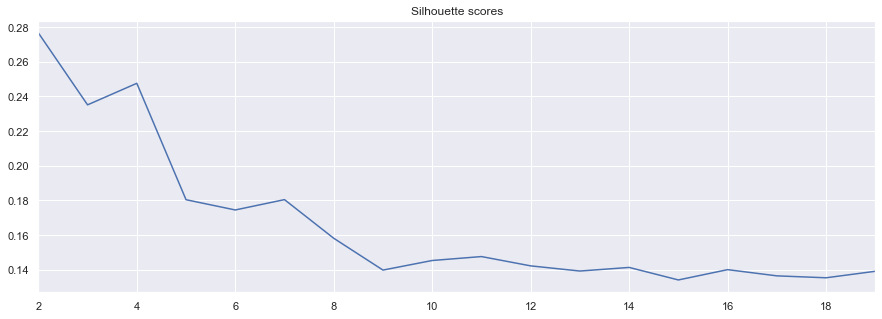

In [115]:
scores = []
for nclust in tqdm(np.arange(2,20)):
    kmeans = KMeans(n_clusters=nclust, random_state=42)
    kmeans.fit(X)
    scores.append(metrics.silhouette_score(X, kmeans.labels_))

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), scores)
plt.grid(True)
plt.xlim(2,19)
plt.title('Silhouette scores')

## Hierarchical clustering

In [116]:
def evaluate_hclust_test(y, link):
    amis, chs, ss, vs = [], [], [], []
    for k in range(2,51):
        clusters = fcluster(link, k, 'maxclust')
        amis.append(metrics.adjusted_mutual_info_score(y, clusters))
        chs.append(metrics.calinski_harabaz_score(X, clusters))
        ss.append(metrics.silhouette_score(X, clusters))
        vs.append(metrics.v_measure_score(y, clusters))
    
    fig, rows = plt.subplots(2, 2, figsize=(15,10))
    rows[0][0].plot(range(2,51), amis)
    rows[0][0].set_xlim(2,50)
    rows[0][0].set_title("adjusted mutual info score")
    rows[0][1].plot(range(2,51), chs)
    rows[0][1].set_xlim(2,50)
    rows[0][1].set_title("calinski harabas score")
    rows[1][0].plot(range(2,51), vs)
    rows[1][0].set_xlim(2,50)
    rows[1][0].set_title("v-score")
    rows[1][1].plot(range(2,51), ss)
    rows[1][1].set_xlim(2,50)
    rows[1][1].set_title("silhouette score")

## Single

In [117]:
single = linkage(pdist(X), 'single')

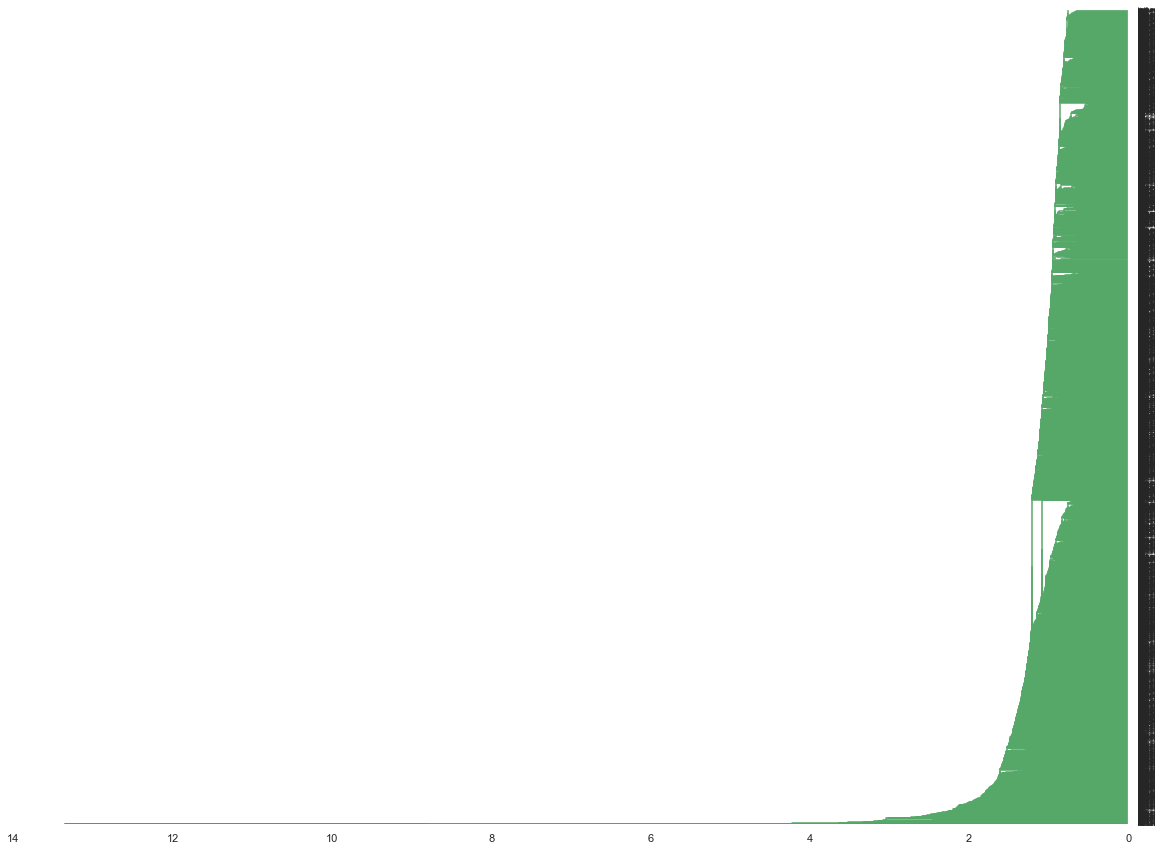

In [118]:
import sys
sys.setrecursionlimit(10000)

fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(single, orientation='left', labels=y, ax=ax)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: Deprecatio

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: Deprecatio

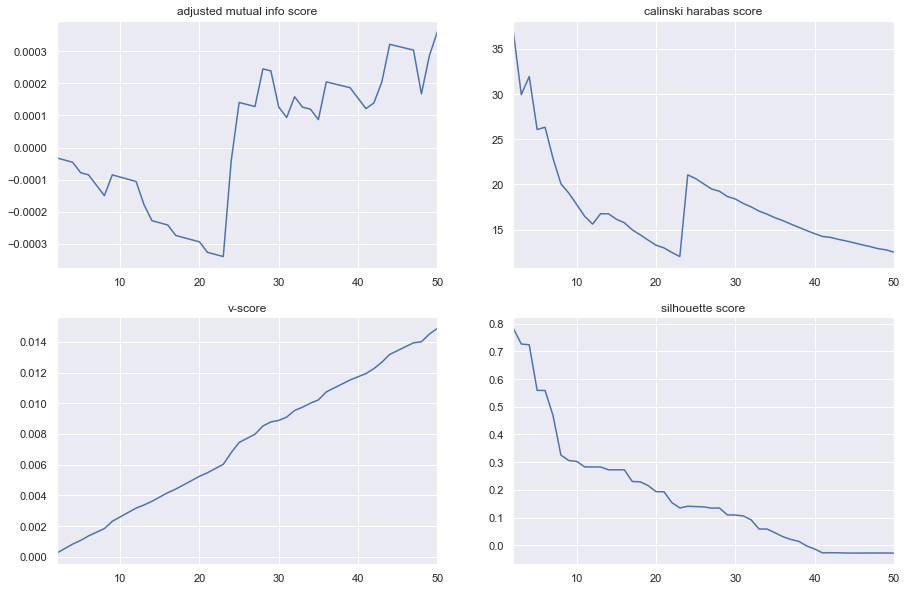

In [119]:
evaluate_hclust_test(y, single)

## Average

In [120]:
average = linkage(pdist(X), 'average')

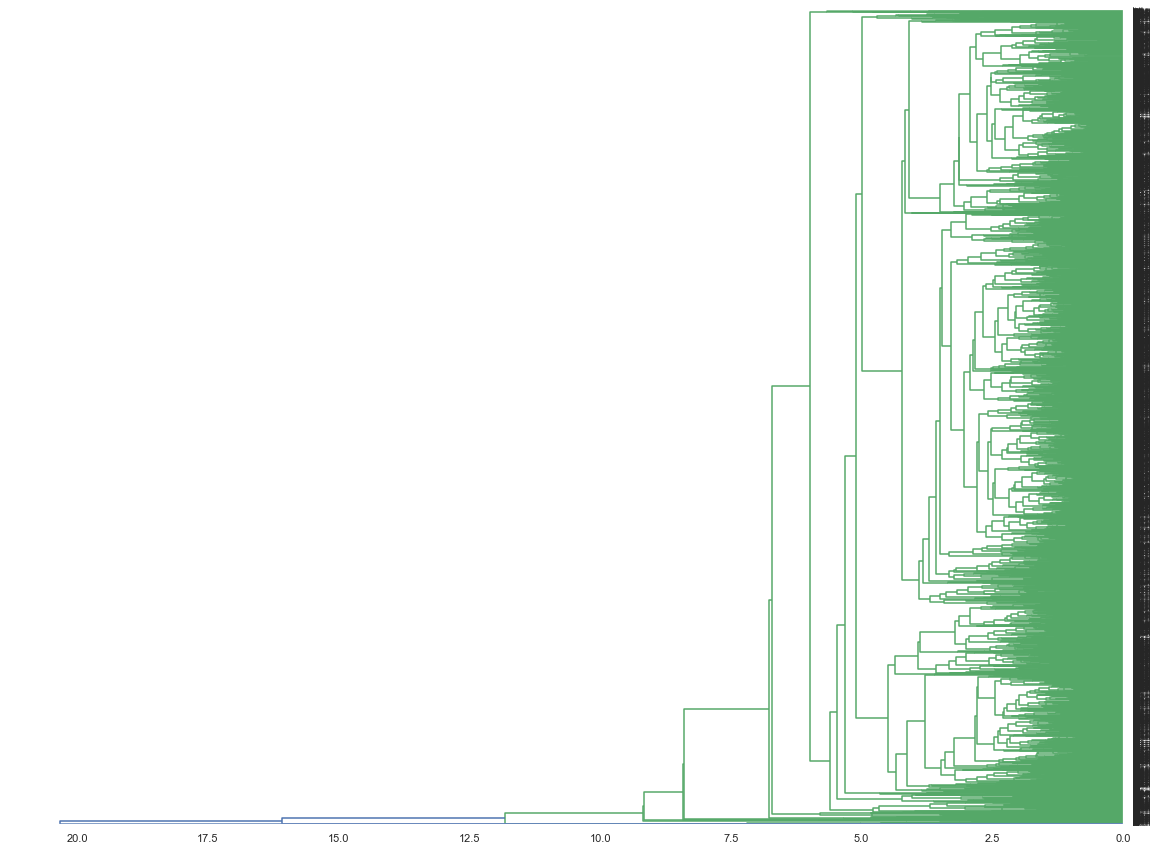

In [121]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(average, orientation='left', labels=y, ax=ax)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: Deprecatio

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: Deprecatio

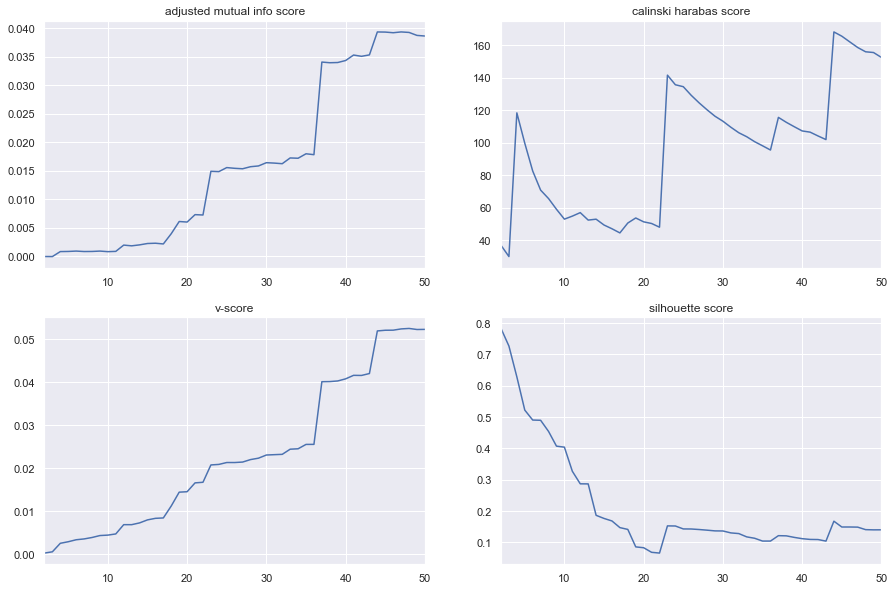

In [122]:
evaluate_hclust(y, average)

## Complete

In [123]:
complete = linkage(pdist(X), 'complete')

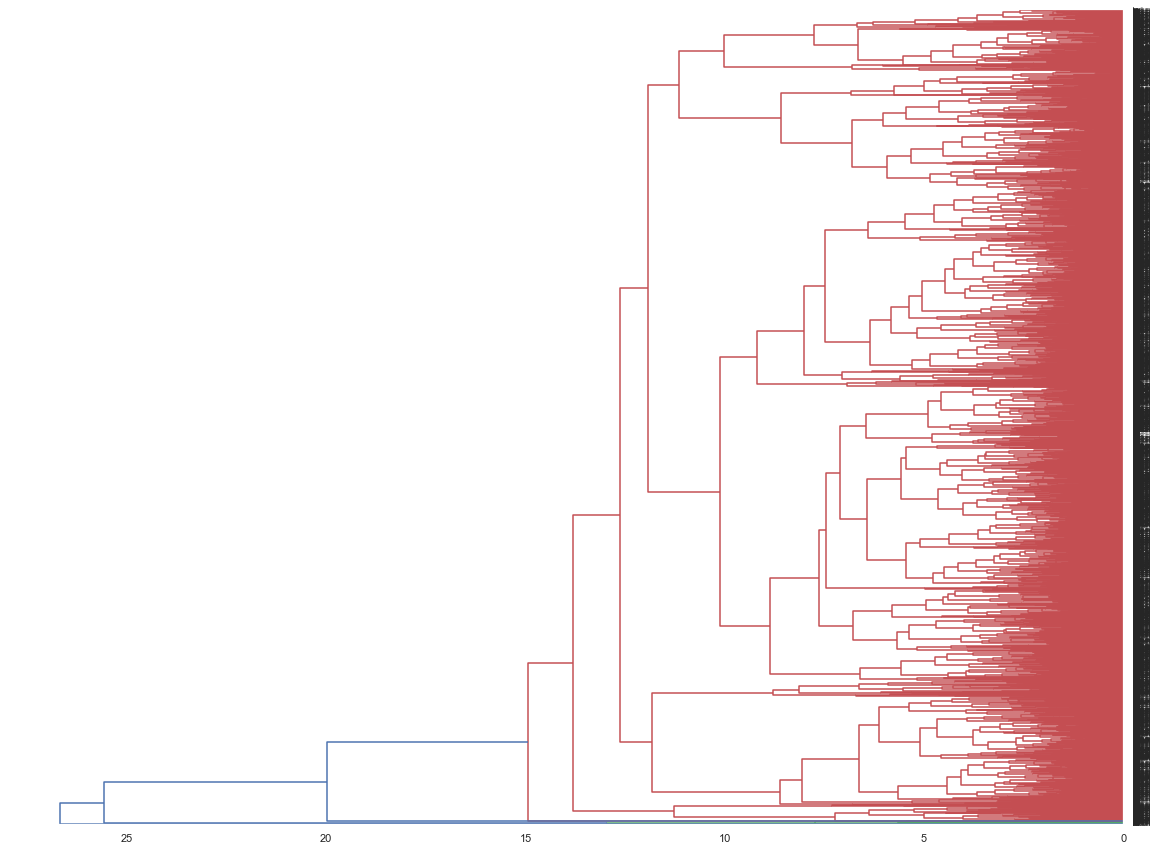

In [124]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(complete, orientation='left', labels=y, ax=ax)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: Deprecatio

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: Deprecatio

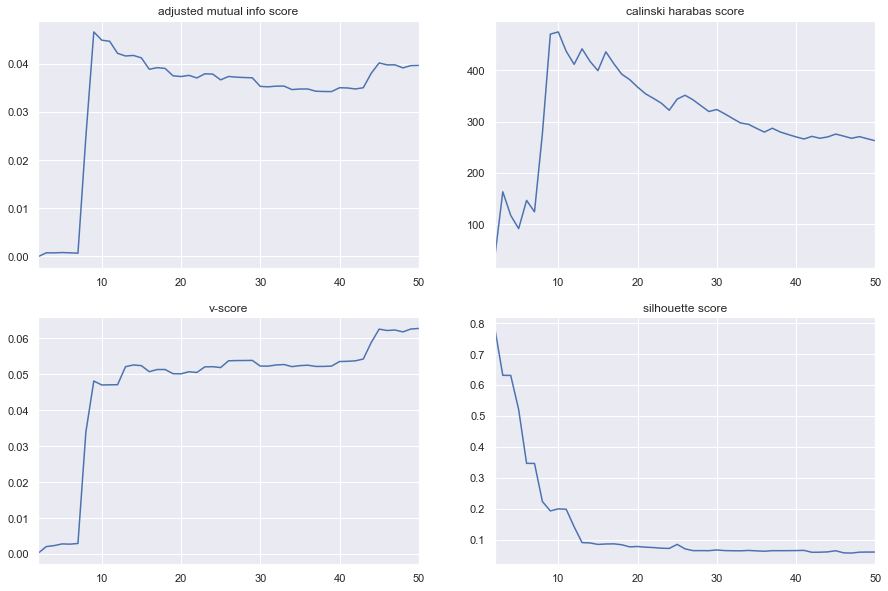

In [125]:
evaluate_hclust(y, complete)

## Matching clusters and classes


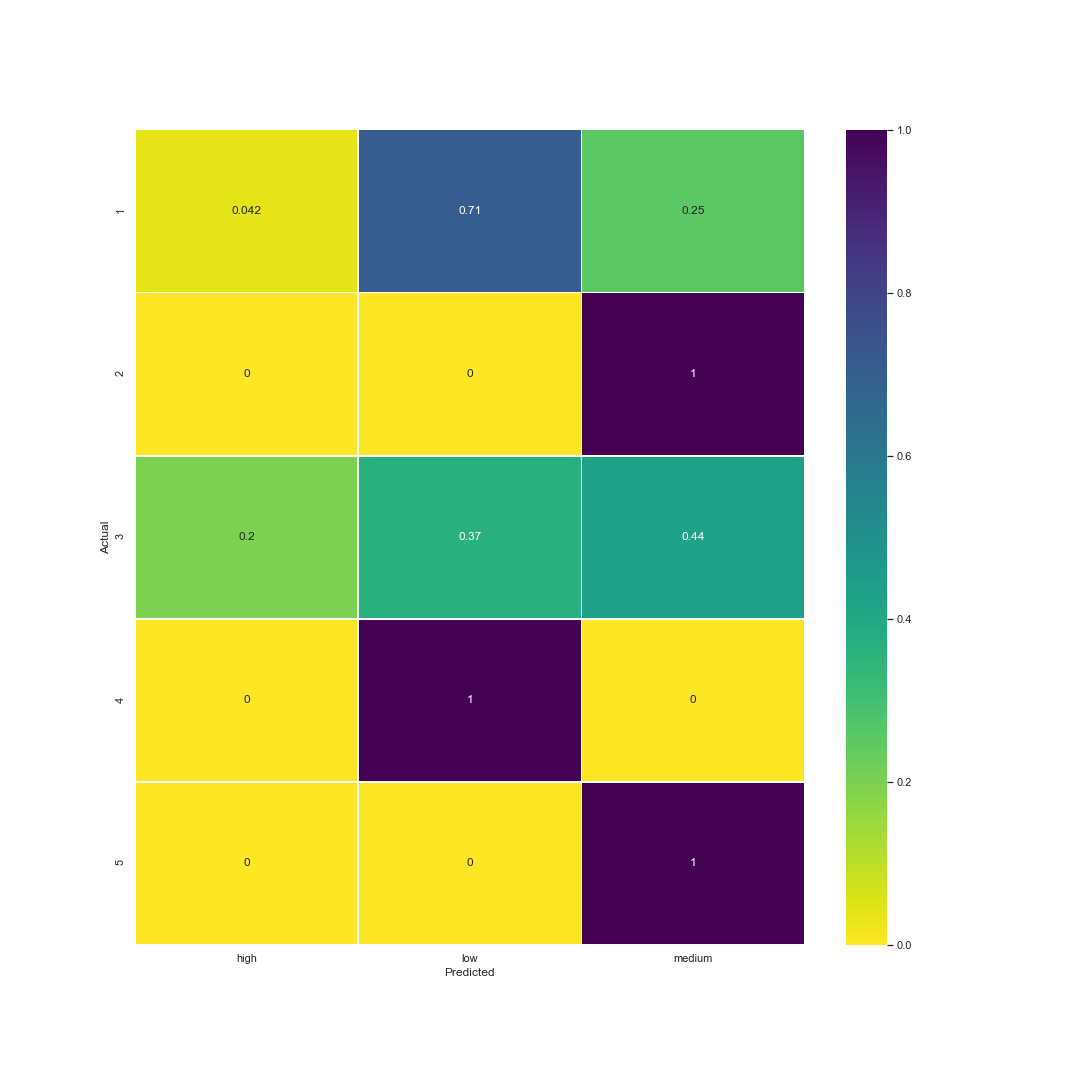

In [126]:
clusters = fcluster(complete, 5, 'maxclust')

metrics.fowlkes_mallows_score(y,clusters)
HTML(confusion_matrix_picture(clusters,y,fs=15))


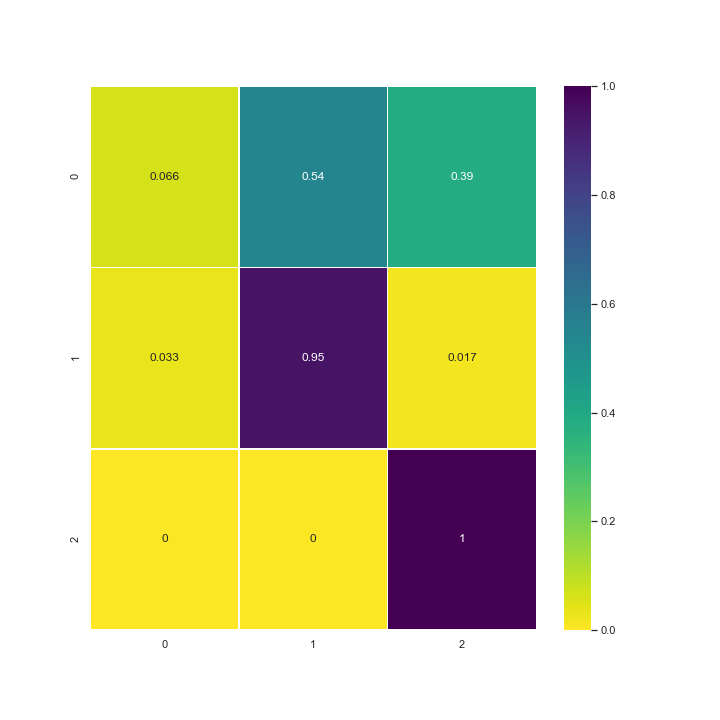

In [127]:
clusters = fcluster(average, 18, 'maxclust')
mm=np.array(confusion_matrix_simple(clusters,y))
from scipy.spatial import distance_matrix, distance
dst=np.zeros([len(mm), len(mm)])
for k in range(len(mm)):
    for j in range(len(mm)):
        dst[k,j]=distance.cosine(mm[k],mm[j])

clust = KMeans(n_clusters = 3, max_iter=5000, algorithm='full').fit(mm)
clusters = clust.predict(mm)

HTML(clust_matrix_picture(clust.cluster_centers_, fs=10))

## Interpretation of clusters

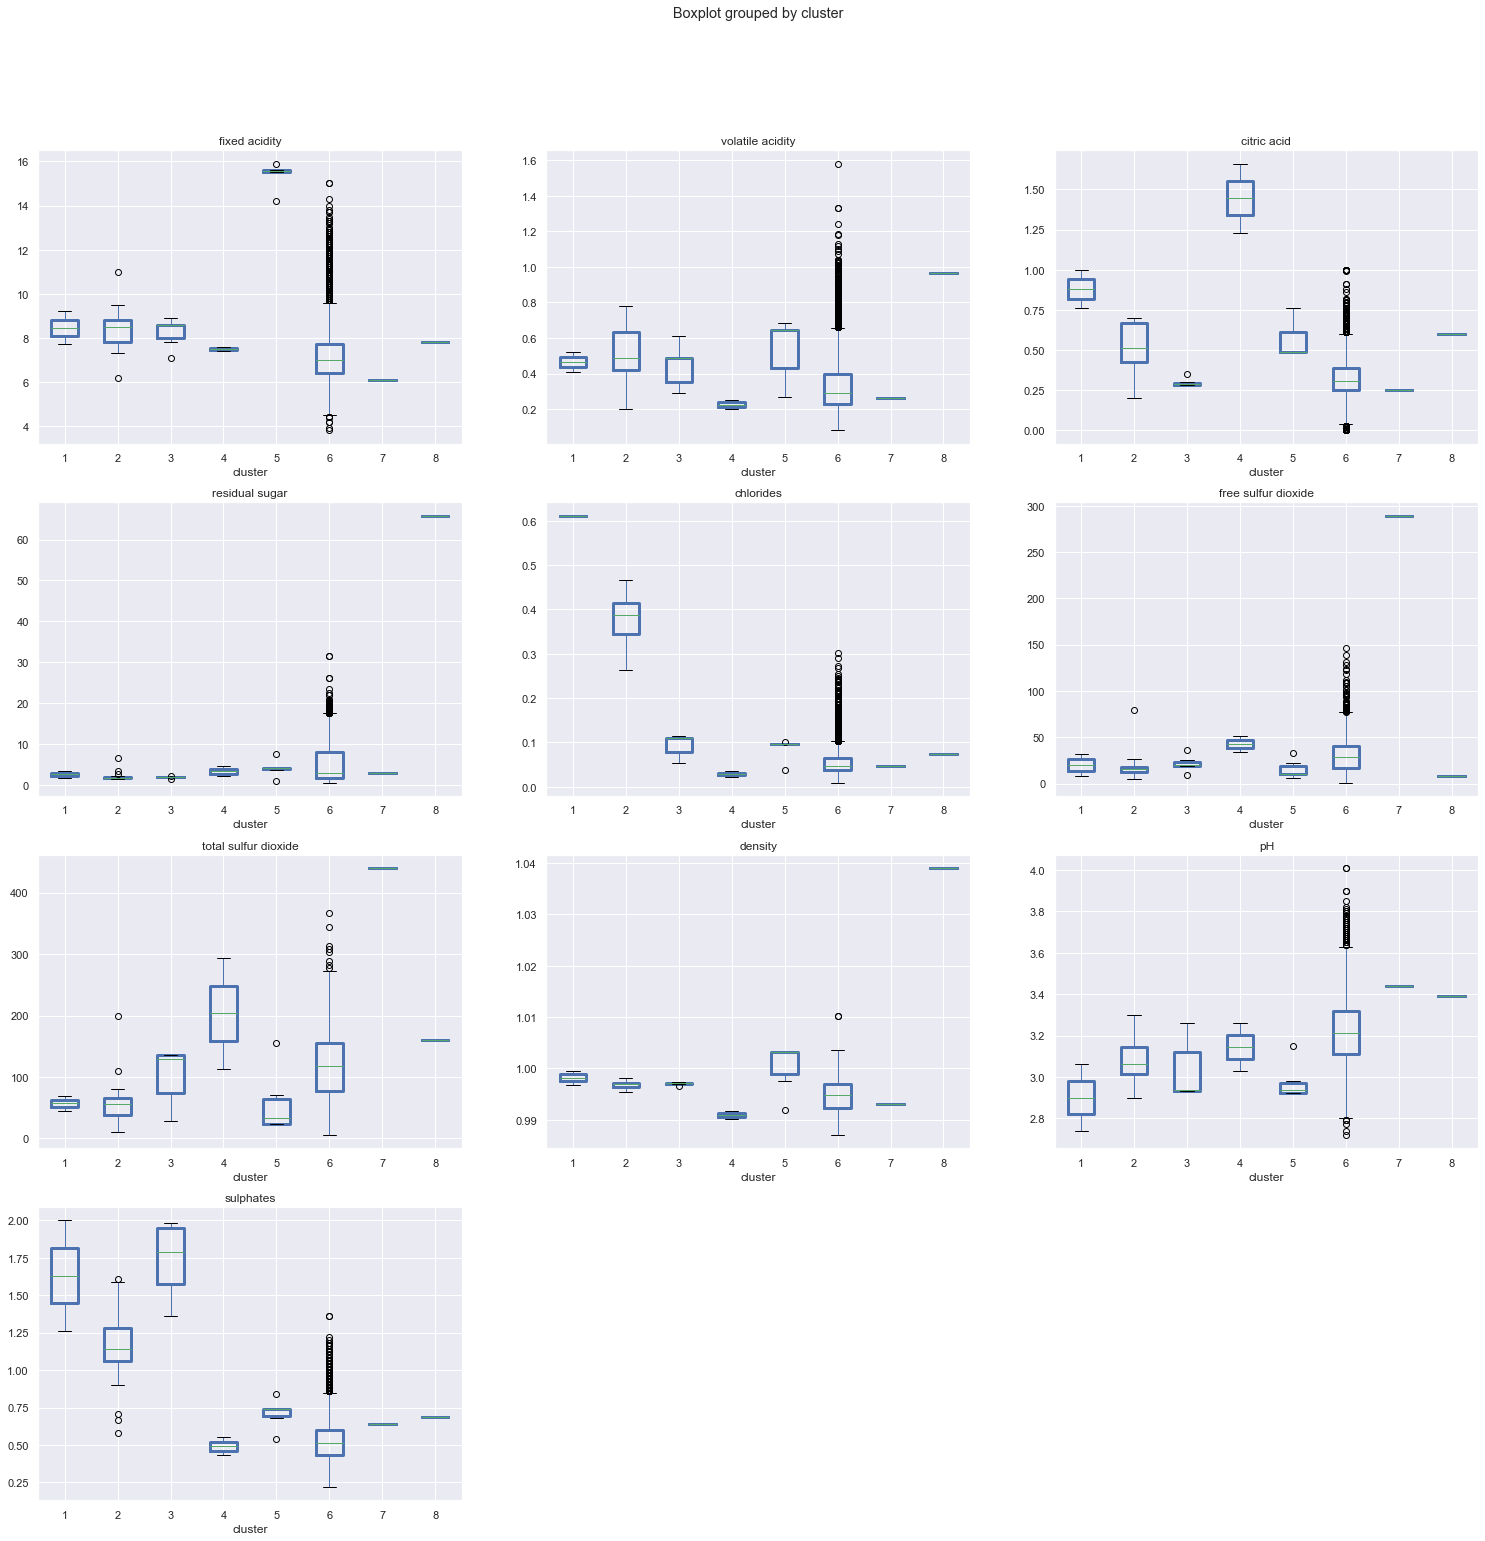

In [128]:
clusters = fcluster(average, 8, 'maxclust')
plt.figure(figsize=[25,25])
k=0
for nm in df.columns[0:10]:
    k=k+1
    ax=plt.subplot(4,3,k)
    ddf=pd.DataFrame({nm:df[nm], 'cluster':clusters})
    ddf.boxplot(nm, 'cluster', ax=ax, boxprops=dict(linestyle='-', linewidth=3, color='k'))